Define the function to load the dataset

In [1]:
def load(dbname, dataset):
    '''
    dbname is the path to the database hdf file, dataset is the dataset name.

    returns a pandas dataframe and a dictionary with meta data for the dataset.
    '''
    attrs = None
    with h5py.File(dbname) as f:
        if dataset not in f.keys():
            raise ValueError('Can\'t find dataset. Available keys are: ' + str(f.keys()))
        try:
            df = pd.DataFrame(dict((k, f[dataset][k][:].ravel()) for k in f[dataset].keys()))
        except ValueError:
            raise RuntimeError('Not all fields have the same length:' +
                str(dict((k, f[dataset][k][:].ravel().shape) for k in f[dataset].keys())))
        if len(f[dataset].attrs.keys())>0:
            attrs = dict((k, f[dataset].attrs[k]) for k in  f[dataset].attrs.keys())

    return df, attrs

Load the dataset

In [2]:
import fixmat
memoryI, meta1 = fixmat.load('Memory_I_raw.hdf', 'Memory I')

C:\Users\User\CASACV\PROGETTO\fixmat.py:23: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(dbname) as f:


# Split dataset in two datasets

In [3]:

iteration1 = memoryI[(memoryI['iteration']==1)]
print(iteration1.shape)
print(iteration1)
print("--------")

iteration5 = memoryI[(memoryI['iteration']==5)]
print(iteration5.shape)
print(iteration5)
print("--------")


(6582993, 11)
          SUBJECTINDEX  category  eye  filenumber  iteration   pupil  sample  \
0                  1.0       7.0  1.0        22.0        1.0  1200.0     1.0   
1                  1.0       7.0  1.0        22.0        1.0  1199.0     2.0   
2                  1.0       7.0  1.0        22.0        1.0  1199.0     3.0   
3                  1.0       7.0  1.0        22.0        1.0  1200.0     4.0   
4                  1.0       7.0  1.0        22.0        1.0  1201.0     5.0   
...                ...       ...  ...         ...        ...     ...     ...   
32303506          45.0      10.0  1.0        55.0        1.0  1040.0  3046.0   
32303507          45.0      10.0  1.0        55.0        1.0  1040.0  3047.0   
32303508          45.0      10.0  1.0        55.0        1.0  1039.0  3048.0   
32303509          45.0      10.0  1.0        55.0        1.0  1039.0  3049.0   
32303510          45.0      10.0  1.0        55.0        1.0  1039.0  3050.0   

          time  trial    

Remove useless rows

In [4]:
iteration1 = iteration1[(iteration1['time']>0)]
print(iteration1.shape)
print("--------")
iteration5 = iteration5[(iteration5['time']>0)]
print(iteration5.shape)


(6469340, 11)
--------
(6474988, 11)


# Define some functions (from detectors.py)

In [5]:
import numpy as np

def remove_missing(x, y, time, missing):
	mx = np.array(x==missing, dtype=int)
	my = np.array(y==missing, dtype=int)
	x = x[(mx+my) != 2]
	y = y[(mx+my) != 2] #why 2?
	time = time[(mx+my) != 2]
	return x, y, time 

def fixation_detection(x, y, time, missing=0.0, maxdist=25, mindur=50):
	
	"""Detects fixations, defined as consecutive samples with an inter-sample
	distance of less than a set amount of pixels (disregarding missing data)
	
	arguments
	x		-	numpy array of x positions
	y		-	numpy array of y positions
	time		-	numpy array of EyeTribe timestamps
	keyword arguments
	missing	-	value to be used for missing data (default = 0.0)
	maxdist	-	maximal inter sample distance in pixels (default = 25) #if >maxdist, is another fixation!
	mindur	-	minimal duration of a fixation in milliseconds; detected
				fixation cadidates will be disregarded if they are below
				this duration (default = 100)
	
	returns
	Sfix, Efix
				Sfix	-	list of lists, each containing [starttime]
				Efix	-	list of lists, each containing [starttime, endtime, duration, endx, endy]
	"""

	x, y, time = remove_missing(x, y, time, missing)

	# empty list to contain data
	Sfix = []
	Efix = []
	
	# loop through all coordinates
	si = 0
	fixstart = False
	for i in range(1,len(x)):
		# calculate Euclidean distance from the current fixation coordinate
		# to the next coordinate
		squared_distance = ((x[si]-x[i])**2 + (y[si]-y[i])**2)
		dist = 0.0
		if squared_distance > 0:
			dist = squared_distance**0.5
		# check if the next coordinate is below maximal distance
		if dist <= maxdist and not fixstart:
			# start a new fixation
			si = 0 + i
			fixstart = True
			Sfix.append([time[i]])
		elif dist > maxdist and fixstart:
			# end the current fixation
			fixstart = False
			# only store the fixation if the duration is ok
			if time[i-1]-Sfix[-1][0] >= mindur:
				Efix.append([Sfix[-1][0], time[i-1], time[i-1]-Sfix[-1][0], x[si], y[si]])
			# delete the last fixation start if it was too short
			else:
				Sfix.pop(-1)
			si = 0 + i
		elif not fixstart:
			si += 1
	#add last fixation end (we can lose it if dist > maxdist is false for the last point)
	if len(Sfix) > len(Efix):
		Efix.append([Sfix[-1][0], time[len(x)-1], time[len(x)-1]-Sfix[-1][0], x[si], y[si]])
	return Sfix, Efix

def saccade_detection(x, y, time, missing=0.0, minlen=5, maxvel=40, maxacc=340):
	
	"""Detects saccades, defined as consecutive samples with an inter-sample
	velocity of over a velocity threshold or an acceleration threshold
	
	arguments
	x		-	numpy array of x positions
	y		-	numpy array of y positions
	time		-	numpy array of tracker timestamps in milliseconds
	keyword arguments
	missing	-	value to be used for missing data (default = 0.0)
	minlen	-	minimal length of saccades in MILLISECONDS; all detected
				saccades with len(sac) < minlen will be ignored
				(default = 5)
	maxvel	-	velocity threshold in pixels/second (default = 40)
	maxacc	-	acceleration threshold in pixels / second**2
				(default = 340)
	
	returns
	Ssac, Esac
			Ssac	-	list of lists, each containing [starttime]
			Esac	-	list of lists, each containing [starttime, endtime, duration, startx, starty, endx, endy]
	"""
	x, y, time = remove_missing(x, y, time, missing)

	# CONTAINERS
	Ssac = []
	Esac = []

	# INTER-SAMPLE MEASURES
	# the distance between samples is the square root of the sum
	# of the squared horizontal and vertical interdistances
	intdist = (np.diff(x)**2 + np.diff(y)**2)**0.5
	# get inter-sample times
	inttime = np.diff(time)
	# recalculate inter-sample times to seconds
	inttime = inttime / 1000.0
	
	# VELOCITY AND ACCELERATION
	# the velocity between samples is the inter-sample distance
	# divided by the inter-sample time
	vel = intdist / inttime
	# the acceleration is the sample-to-sample difference in
	# eye movement velocity
	acc = np.diff(vel)

	# SACCADE START AND END
	t0i = 0
	stop = False
	while not stop:
		# saccade start (t1) is when the velocity or acceleration
		# surpass threshold, saccade end (t2) is when both return
		# under threshold
	
		# detect saccade starts
		sacstarts = np.where((vel[1+t0i:] > maxvel).astype(int) + (acc[t0i:] > maxacc).astype(int) >= 1)[0]
		if len(sacstarts) > 0:
			# timestamp for starting position
			t1i = t0i + sacstarts[0] + 1
			if t1i >= len(time)-1:
				t1i = len(time)-2
			t1 = time[t1i]
			
			# add to saccade starts
			Ssac.append([t1])
			
			# detect saccade endings
			sacends = np.where((vel[1+t1i:] < maxvel).astype(int) + (acc[t1i:] < maxacc).astype(int) == 2)[0]
			if len(sacends) > 0:
				# timestamp for ending position
				t2i = sacends[0] + 1 + t1i + 2
				if t2i >= len(time):
					t2i = len(time)-1
				t2 = time[t2i]
				dur = t2 - t1

				# ignore saccades that did not last long enough
				if dur >= minlen:
					# add to saccade ends
					Esac.append([t1, t2, dur, x[t1i], y[t1i], x[t2i], y[t2i]])
				else:
					# remove last saccade start on too low duration
					Ssac.pop(-1)

				# update t0i
				t0i = 0 + t2i
			else:
				stop = True
		else:
			stop = True
	
	return Ssac, Esac

We want to know which categories and which images are involved in the 1st and in the 5th iteration

In [6]:
category_values_1 = iteration1.category.unique()
category_values_5 = iteration5.category.unique()

print(category_values_1)
print(category_values_5)

[ 7. 11.  8. 10.]
[ 8. 10.  7. 11.]


We are going to collect filenumber of each image for each category involved in this work: we have 12 images for each of them.

Let's store file numbers of clear images (natural-urban) in a list, file numbers of unclear images (fractal-pink noise) in another list.

After doing this, let's store these 2 lists in another big list that will contain all filenumbers: so it will be a 2 elements list. In turn, each element is a list of other 2 elements (respectively natural-urban and fractal-pink noise).

Summarizing:

filenumber = [ 

               [
                [natural images id]
                [urban images id]
               ]
               
               [
                [fractal images id]
                [pink noise id]
               ]
               
            ]

In [7]:
natural = iteration1[iteration1['category'] == 7.0]['filenumber'].unique()
urban = iteration1[iteration1['category'] == 8.0]['filenumber'].unique()
fractal = iteration1[iteration1['category'] == 10.0]['filenumber'].unique()
pinknoise = iteration1[iteration1['category'] == 11.0]['filenumber'].unique()

print((natural)) #category 7
print((urban))#category8
print((fractal))#category10
print((pinknoise))#category11


filenumber =  []

clear_images = []
unclear_images = []

clear_images.append(natural)
clear_images.append(urban)

unclear_images.append(fractal)
unclear_images.append(pinknoise)

filenumber.append(clear_images) #category 7-8
filenumber.append(unclear_images) #category 10-11

print(filenumber)

[22.  5. 29. 17. 30. 19. 46. 28. 43. 20. 27. 45.]
[31.  3.  7. 56. 14.  1. 29. 48. 46. 33. 35. 13.]
[ 2. 43. 19.  3.  9. 50. 44. 18. 55. 31. 52. 62.]
[29.  7.  5. 32. 31. 55. 56.  6. 30. 57.  4. 54.]
[[array([22.,  5., 29., 17., 30., 19., 46., 28., 43., 20., 27., 45.]), array([31.,  3.,  7., 56., 14.,  1., 29., 48., 46., 33., 35., 13.])], [array([ 2., 43., 19.,  3.,  9., 50., 44., 18., 55., 31., 52., 62.]), array([29.,  7.,  5., 32., 31., 55., 56.,  6., 30., 57.,  4., 54.])]]


Now we want to detect fixations of ALL the participants for each image involved in 1st and 5th iteration. 

As before, we want to consider (and not discard) similar fixations of different participants, and not concatenate all them and pass them to the script.

However, before we have worked with just one image (number 22)... now we want to perform clustering on ALL the images, of each category, so we need a multidimensional list.

We will access to each filenumber stored in the filenumbers list to correctly get the values from the dataset: to do this, in fact, we need not only the filenumber, but also the category related. 

So we use a variable 'category' that will change when we will move trough the different categorized lists of the filenumbers list.

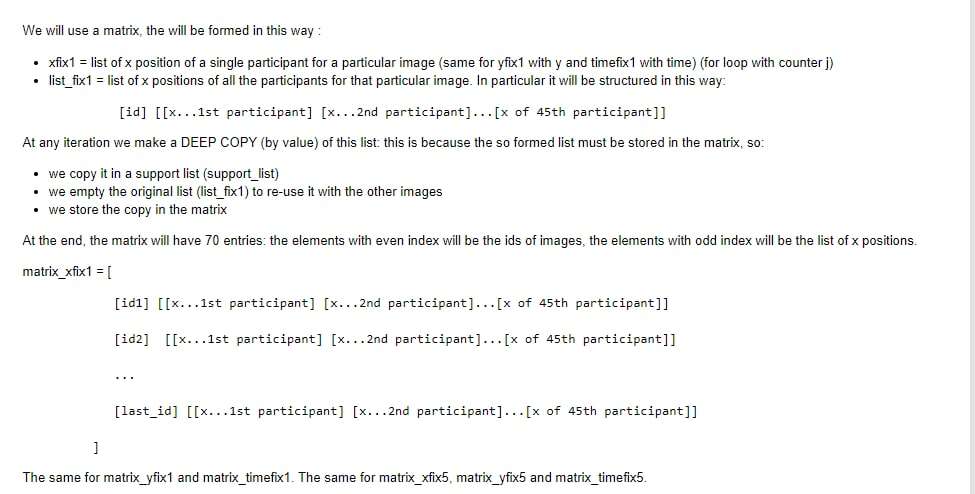

As id of this big matrix we will use a simple counter, not the real filenumber: this is because we know that we have exactly 12 images for each category, that means that we have 24 clear images and 24 unclear images.

So we just use a variable 'id', that goes from 0 to 47: the first 24 are clear, the others are unclear. We keep in mind this, it's enough for our work.

In [8]:
from copy import deepcopy #to copy list by values and not by reference
matrix_xfix1 = []
matrix_yfix1 = []
matrix_timefix1 = []

xfix1 = [] #list of x position of a single participant
yfix1 = [] #list of y position of a single participan
timefix1 = [] #list of times of a single participan

list_xfix1 = [] #it will be a list of 2 elements: [image id] [lists of x position of ALL the participants]
list_yfix1 = []
list_timefix1 = []

image_id = [] #list of one element,it will contain the image_id
id = 0 #
category = 0 #this variable will be updated accordingly to the list of filenumber which we are in
for k in range (0,2): #access to 2 lists of filenumber
#     print(filenumber[k])
        for i in range (0,2): #access to 2 lists of clear e unclear: respectively natural-urban and fractal-pink noise
            if(k==0):
                if(i==0): category = 7
                else: category = 8
            else: 
                if(i==0): category = 10
                else: category = 11
            for l in range (0,12): #id : 0-12 because for each category we have exactly 12 images
                id = id+1
#                 print(id, category)
#                 print(filenumber[k][i][l])
                del list_xfix1[:]
                del list_yfix1[:]
                del list_timefix1[:]

                del image_id[:]
                del xfix1[:]
                del yfix1[:]
                del timefix1[:]

                image_id.append(id) #store image_id in a list (single element)
                list_xfix1.append(image_id)  #store the single element list (id) in the list explained above
                list_yfix1.append(image_id)  #store the single element list (id) in the list explained above
                list_timefix1.append(image_id)  #store the single element list (id) in the list explained above

                #we have filled the first element of the multidimensional list
                #now let's fill the second element: a list of lists
                for j in range (1,46): #participants = 46!!!!!!
                        each_image = iteration1[(iteration1['filenumber']==filenumber[k][i][l]) & (iteration1['SUBJECTINDEX']==j) & (iteration1['category']==category)] #data of each image
                        xfixj = [(each_image['x'])] #list of x positions of each image of j partecipant
                        yfixj = [(each_image['y'])] #list of y positions of each image of j partecipant
                        timefixj = [(each_image['time'])] #list of times of each image of j partecipant

                        xfix1.append(xfixj) #append these j lists in a bigger list
                        yfix1.append(yfixj) #append these j lists in a bigger list
                        timefix1.append(timefixj) #append these j lists in a bigger list

                list_xfix1.append(xfix1) #append these big lists in the list explained above
                list_yfix1.append(yfix1) #append this big lists in the list explained above
                list_timefix1.append(timefix1) #append this big lists in the list explained above

               # print(list_xfix1) #list of[ [id] [ [x of 1st participant] [x of 2nd participnt]...] ]

                support_xlist = deepcopy(list_xfix1) #copy
                del list_xfix1[:] #empty the list

                support_ylist = deepcopy(list_yfix1) #copy
                del list_yfix1[:] #empty the list

                support_timelist = deepcopy(list_timefix1) #copy
                del list_timefix1[:] #empty the list

            #     print(support_xlist)
                matrix_xfix1.extend(support_xlist) #store the copy in the matrix
                matrix_yfix1.extend(support_ylist) #store the copy in the matrix
                matrix_timefix1.extend(support_timelist) #store the copy in the matrix




In [9]:
# # #SOME PRINTS FOR DEBUGGING
# print((matrix_xfix1))
# print()
# # print((matrix_xfix1))

# # # print("----")
# # # print(matrix_xfix1) #list of[ [id] [ [x of 1st participant] [x of 2nd participnt]...] ]
# # # print("----\n\n\n")
# print(matrix_xfix1[0]) #id of first image
# print(len(matrix_xfix1[1])) #list of x position of the first image of all participants
# # print("\n\n\n\n")
# # print(matrix_xfix1[1][0]) #list of x position of the first image of the first participant
# # print(len(matrix_xfix1[1][0][0])) #n° of fixations on the first image of the firsrt participant
# # # print("----\n\n\n")
# print(matrix_xfix1[2]) #id of second image
# print(len(matrix_xfix1[3]))#list of x position of the second image of all participants
# print(len(matrix_xfix1[95]))#list of x position of the second image of all participants

# # # print("----\n\n\n")
# # # print(matrix_xfix1[3][0]) #list of x position of the second image of the 1st participant
# # print("\n\n\n\n")
# # # print((matrix_yfix1))
# # # # print("----")
# # # # print(matrix_yfix1) #list of[ [id] [ [y of 1st participant] [x of 2nd participnt]...] ]
# # # # print("----\n\n\n")
# # # print(matrix_yfix1[0]) #id of first image
# # # # print(matrix_yfix1[1]) #list of y position of the first image of all participants
# # # # print("----\n\n\n")
# # # # print(matrix_yfix1[2]) #id of second image
# # # # print(matrix_yfix1[3]) #list of y position of the second image of all participants
# # # # print("----\n\n\n")
# # # # print(matrix_yfix1[3][0]) #list of y position of the second image of the 1st participant

# # # print(len(matrix_timefix1))
# # # # print("----")
# # # # print(matrix_timefix1) #list of[ [id] [ [time of 1st participant] [x of 2nd participnt]...] ]
# # # # print("----\n\n\n")
# # # # print(matrix_timefix1[0]) #id of first image
# # # # print(matrix_timefix1[1]) #list of time position of the first image of all participants
# # # # print("----\n\n\n")
# # # # print(matrix_timefix1[2]) #id of second image
# # # # print(matrix_timefix1[3]) #list of time position of the second image of all participants
# # # # print("----\n\n\n")
# # # # print(matrix_timefix1[3][0]) #list of time position of the second image of the 1st participant


In [10]:
# print(matrix_n_fixations_per_image)
# print("\n\n")
# print(matrix_n_fixations_per_image[0]) #id first image
# print("\n\n")
# print(matrix_n_fixations_per_image[1]) #number of fixations of each participant on that image


Repeat the same elaboration with data of 5th iteration

In [11]:
from copy import deepcopy #to copy list by values and not by reference
matrix_xfix5 = []
matrix_yfix5 = []
matrix_timefix5 = []

xfix5 = [] #list of x position of a single participant
yfix5 = [] #list of y position of a single participan
timefix5 = [] #list of times of a single participan

list_xfix5 = [] #it will be a list of 2 elements: [image id] [lists of x position of ALL the participants]
list_yfix5 = []
list_timefix5 = []

image_id = [] #list of one element,it will contain the image_id
id = 0
category = 0
for k in range (0,2): #access to 2 lists of filenumber
#     print(filenumber[k])
        for i in range (0,2): #access to 2 lists of clear e unclear
            if(k==0):
                if(i==0): category = 7
                else: category = 8
            else: 
                if(i==0): category = 10
                else: category = 11
            for l in range (0,12): #idddd
                id = id+1
#                 print(id, category)
#                 print(filenumber[k][i][l])
                del list_xfix5[:]
                del list_yfix5[:]
                del list_timefix5[:]

                del image_id[:]
                del xfix5[:]
                del yfix5[:]
                del timefix5[:]

                image_id.append(id) #store image_id in a list (single element)
                list_xfix5.append(image_id)  #store the single element list (id) in the list explained above
                list_yfix5.append(image_id)  #store the single element list (id) in the list explained above
                list_timefix5.append(image_id)  #store the single element list (id) in the list explained above

                #we have filled the first element of the multidimensional list
                #now let's fill the second element: a list of lists
                for j in range (1,46): #participants = 46!!!!!!
                        each_image = iteration5[(iteration5['filenumber']==filenumber[k][i][l]) & (iteration5['SUBJECTINDEX']==j) & (iteration5['category']==category) ] #data of each image
                        xfixj = [(each_image['x'])] #list of x positions of each image of j partecipant
                        yfixj = [(each_image['y'])] #list of y positions of each image of j partecipant
                        timefixj = [(each_image['time'])] #list of times of each image of j partecipant

                        xfix5.append(xfixj) #append these j lists in a bigger list
                        yfix5.append(yfixj) #append these j lists in a bigger list
                        timefix5.append(timefixj) #append these j lists in a bigger list

                list_xfix5.append(xfix5) #append these big lists in the list explained above
                list_yfix5.append(yfix5) #append this big lists in the list explained above
                list_timefix5.append(timefix5) #append this big lists in the list explained above

               # print(list_xfix1) #list of[ [id] [ [x of 1st participant] [x of 2nd participnt]...] ]

                support_xlist5 = deepcopy(list_xfix5) #copy
                del list_xfix5[:] #empty the list

                support_ylist5 = deepcopy(list_yfix5) #copy
                del list_yfix5[:] #empty the list

                support_timelist5 = deepcopy(list_timefix5) #copy
                del list_timefix5[:] #empty the list

            #     print(support_xlist)
                matrix_xfix5.extend(support_xlist5) #store the copy in the matrix
                matrix_yfix5.extend(support_ylist5) #store the copy in the matrix
                matrix_timefix5.extend(support_timelist5) #store the copy in the matrix




In [12]:
# #SOME PRINTS FOR DEBUGGING
# print(len(matrix_xfix5))
# print("----")
# print(matrix_xfix5) #list of[ [id] [ [x of 1st participant] [x of 2nd participnt]...] ]
# print("----\n\n\n")
# print(matrix_xfix5[0]) #id of first image
# print(len(matrix_xfix5[1])) #list of x position of the first image of all participants
# # print("----\n\n\n")
# # print(matrix_xfix5[2]) #id of second image
# print(len(matrix_xfix5[3])) #list of x position of the second image of all participants
# # print("----\n\n\n")
# print(matrix_xfix5[3][0]) #list of x position of the second image of the 1st participant
# print(len(matrix_xfix5[95])) #list of x position of the second image of all participants

# # print(len(matrix_yfix5))
# # print("----")
# # print(matrix_yfix5) #list of[ [id] [ [y of 1st participant] [x of 2nd participnt]...] ]
# # print("----\n\n\n")
# # print(matrix_yfix5[0]) #id of first image
# # print(matrix_yfix5[1]) #list of y position of the first image of all participants
# # print("----\n\n\n")
# # print(matrix_yfix5[2]) #id of second image
# # print(matrix_yfix5[3]) #list of y position of the second image of all participants
# # print("----\n\n\n")
# # print(matrix_yfix5[3][0]) #list of y position of the second image of the 1st participant

# # print(len(matrix_timefix5))
# # print("----")
# # print(matrix_timefix5) #list of[ [id] [ [time of 1st participant] [x of 2nd participnt]...] ]
# # print("----\n\n\n")
# # print(matrix_timefix5[0]) #id of first image
# # print(matrix_timefix5[1]) #list of time position of the first image of all participants
# # print("----\n\n\n")
# # print(matrix_timefix5[2]) #id of second image
# # print(matrix_timefix5[3]) #list of time position of the second image of all participants
# # print("----\n\n\n")
# # print(matrix_timefix5[3][0]) #list of time position of the second image of the 1st participant


Now we will pass separately each batch of data for each participant to the function

Also in this case we will use a matrix: now we want to start to group data related to the same image.

So, we pass separately each batch of data of each participant, we collect list (partial_Efix1, it will contain lists of starttime, endtime, duration, endx, endy of each fixation for each participant on a particular image)  and we concatenate them 45 at a time (in all_Efix1). (because participants are 45)

all_Efix1 = [ 
                [starttime, endtime, endx, endy of the first participant for that image],
                
                [starttime, endtime, endx, endy of the second participant for that image]
               
               ...
            ]
            
          

When the participant loop is over, and we want to start with the next image, we append all_Efix1 to a previously prepared list_Efix1, in which we have already stored the id of the image just analyzed.

list_Efix1 = [

                [id], [all_Efix1 of a certain image]

                [id], [all_Efix1 of a certain image]
                
                ...
                
             ]

And, as before, we make a copy by values of this list and we store it in a big matrix_Efix1, before empty all these lists that will be reused with the other images.

Even indexes for id, odd for data related to it.

In [13]:
all_Sfix1 = []
all_Efix1 = []

partial_Efix1 = []

list_Efix1 = []

matrix_Efix1 = []

image_id = [] #list of one element, will contain the image_id
#N.B. Don't forget: these are the indexes


index = 0 #to access to odd indexes of matrix (even = id, odd = data related to)

for i in range(0, len(matrix_xfix1), 2): #goes through the image_id: i = 0,2,4,6...
    index = i+1 
    del list_Efix1[:] #empty the list
    del image_id[:]
    del partial_Efix1[:]
    del all_Efix1[:]
    image_id.append(matrix_xfix1[i]) #store image_id in a list (single element): usiamo i che è pari
    list_Efix1.append(image_id)
    for j in range(0, len(matrix_xfix1[index])): #goes through participants: every 45 times, il will change the image
        partial_Sfix1, partial_Efix1 = fixation_detection(np.array(matrix_xfix1[index][j]), np.array(matrix_yfix1[index][j]), np.array(matrix_timefix1[index][j]), missing=0.0, maxdist=25, mindur=50)
        all_Sfix1.append(partial_Sfix1)
        all_Efix1.append(partial_Efix1)
    list_Efix1.append(all_Efix1)
 
    support_Efix1_list = deepcopy(list_Efix1) #copy
    del list_Efix1[:] #empty the list
#     print("SUPPORTO", support_Efix1_list)
    matrix_Efix1.extend(support_Efix1_list) #store the copy in the matrix

    
#SOME PRINTS for debug
# print("Tutta la matrice:\n" ,matrix_Efix1) 
# # print("\n\n")
# print("lunghezza: ", len(matrix_Efix1))
# print("\n\n")
# # print(matrix_Efix1[0])    #id of firtst image
# # print("\n\n")
# print((matrix_Efix1[1]))    #data about fixations of all participants on the frist image
# # print("\n\n")
# print(matrix_Efix1[1][0])#data about fixation of the first participant on the frist image
# print("\n\n")
# print(matrix_Efix1[1][1])#data about fixation of the first participant on the frist image
# print("\n\n")
# print(matrix_Efix1[1][2])#data about fixation of the first participant on the frist image
# print("\n\n")
# print(matrix_Efix1[1][3])#data about fixation of the first participant on the frist image
# print("\n\n")
# # print(matrix_Efix1[1][4])#data about fixation of the first participant on the frist image
# print("\n\n")
# # print(matrix_Efix1[1][0][0]) #data about first fixation of the firs particcipant on the first image [starttime, endtime,...]
# # print("\n\n")
# # print(matrix_Efix1[1][0][0][3]) #last depth level: endx of the first fixation of the first participant on the first image

In [14]:
# # #SOME PRINTS for debug
# # print("Tutta la matrice:\n" ,matrix_Efix1) 
# # # print("\n\n")
# print("lunghezza: ", len(matrix_Efix1))
# # print("\n\n")
# print(matrix_Efix1[0])    #id of firtst image
# # # print("\n\n")
# print(len(matrix_Efix1[1]))    #data about fixations of all participants on the frist image
# # # print("\n\n")
# print(matrix_Efix1[94])    #id of firtst image
# # # print("\n\n")
# print(len(matrix_Efix1[95])) 
# # print(matrix_Efix1[1][0])#data about fixation of the first participant on the frist image
# # print("\n\n")
# # print(matrix_Efix1[1][1])#data about fixation of the second participant on the frist image
# # print("\n\n")
# # print(matrix_Efix1[1][2])#data about fixation of the third participant on the frist image
# # print("\n\n")
# # print(matrix_Efix1[1][3])#data about fixation of the fourth participant on the frist image
# # print("\n\n")
# # # print(matrix_Efix1[1][4])#data about fixation of the fifth participant on the frist image
# # print("\n\n")
# # # print(matrix_Efix1[1][0][0]) #data about first fixation of the firs particcipant on the first image [starttime, endtime,...]
# # # print("\n\n")
# # # print(matrix_Efix1[1][0][0][3]) #last depth level: endx of the first fixation of the first participant on the first image

# [1ST ITERATION] NUMBER OF FIX. OF EACH PARTICIPANT PER IMAGE

From this matrix, now, we want the number of fixations for each participant on each image: this will be an important information that we will use in the final dataset.

Also in this case we build a matrix, whose structure will be the same as usual: 

matrix_number_fix_per_image = [
    
                               [ [id1] [ [n fix of 1st p] [n fix of 2nd p]...[n fix of 45th p]]
                               
                                 [id2] [ [n fix of 1st p] [n fix of 2nd p]...[n fix of 45th p]
                                 
                                 ...
                                 
                                 ]
                                

In [15]:
image_id = []

n_fix_j = [] #number of fixations of j participant on a particular image

list_n_fixations = [] #list with number of fixations of all participants on a particular image

matrix_number_fix_per_image = [] #[[id] list_n_fixations on that image]

for i in range (0, len(matrix_Efix1), 2): # 0,2,4...,(even index with id)
    del image_id[:]
    del n_fix_j[:]
    del list_n_fixations[:]
    
    index = i+1  #access to data (odd index)
    list_n_fixations.append(matrix_Efix1[i][0]) #id
    for j in range (0, len(matrix_Efix1[index])): #data related to that image with that id
        n_fix_j.append(len(matrix_Efix1[index][j])) #append number of fixation of fixations of j-participant on that img
        
    list_n_fixations.append(n_fix_j)
    support_nfixations = deepcopy(list_n_fixations) #copy
    del list_n_fixations[:] #empty the list

    matrix_number_fix_per_image.extend(support_nfixations) #store the copy in the matrix


In [16]:
# print(len(matrix_number_fix_per_image[95]))
# # print("\n\n")
# # print(matrix_number_fix_per_image[0]) #id first image
# # print(matrix_number_fix_per_image[1]) #number of fixations of each participant on that image
# # print(matrix_number_fix_per_image[1][0]) #number of fixations of first participant on that image
# # # print(matrix_number_fix_per_image[3]) #id second  image


# [1ST ITERATION] MEAN DURATION OF FIXATION OF EACH PARTICIPANT PER IMAGE

From Efix matrix, now, we want the mean duration of fixations for each participant on each image: this will be an important information that we will use in the final dataset.

Also in this case we build a matrix, whose structure will be the same as usual

In [17]:
image_id = []

duration_j = [] #list with duration of each fixation of A SINGLE participant on a particular image

mean_durations_j_perImage = []  # mean duration of j participants per each image

list_durations = [] #list with all duration of all participants on a particular image

matrix_meanDuration_eachParticipant_perImage = [] #[[id] list_duration of fixations on that image]

for i in range (0, len(matrix_Efix1), 2): #0,2,4...,(even index with id)
#     del image_id[:]
    del duration_j[:]
    del list_durations[:]
    del mean_durations_j_perImage[:]
    
    index = i+1  #access to odd index with data
    list_durations.append(matrix_Efix1[i][0]) #id
    for j in range (0, len(matrix_Efix1[index])): #through participants' data on that image
#         print("nuova partecipane")
        for k in range (0, len(matrix_Efix1[index][j])): #though fixations of j partecipant 
            duration_j.append(matrix_Efix1[index][j][k][2]) #access to data that we want: duration is at index 2 
#             print(np.mean(duration_j, axis = 0))

    
        mean_durations_j_perImage.append(round((np.mean(duration_j, axis = 0)),2)) #mean duration
#         print(mean_durations_j_perImage)

    
    list_durations.append(mean_durations_j_perImage) 
#     print(list_durations)
    
    support_durations = deepcopy(list_durations) #copy
    del list_durations[:] #empty the list

    matrix_meanDuration_eachParticipant_perImage.extend(support_durations) #store the copy in the matrix



In [18]:
# print(matrix_meanDuration_eachParticipant_perImage)
# print("\n\n")
# print(matrix_meanDuration_eachParticipant_perImage[0]) #id first image
# print("\n\n")
# print(matrix_meanDuration_eachParticipant_perImage[1]) #mean durations of fixations of eeach part. on first img
# print("\n\n")
# print(matrix_meanDuration_eachParticipant_perImage[1][0]) #mean durations of fixations of first part. on first img


# Repeat the same for 5th iteration

In [19]:
all_Sfix5 = []
all_Efix5 = []

partial_Efix5 = []

list_Efix5 = []

matrix_Efix5 = []

image_id = [] #list of one element, will contain the image_id
#N.B. Don't forget: these are the indexes


index = 0 #per accedere agli elementi DISPARI della matrix, ovvero alle liste delle fissazioni

for i in range(0, len(matrix_xfix5), 2): #scorre le immagini: i = 0,2,4,6...70
    index = i+1 #per accedere agli elementi DISPARI della matrix, ovvero alle liste delle fissazioni
    del list_Efix5[:] #empty the list
    del image_id[:]
    del partial_Efix5[:]
    del all_Efix5[:]
    image_id.append(matrix_xfix5[i]) #store image_id in a list (single element): usiamo i che è pari
    list_Efix5.append(image_id)
    for j in range(0, len(matrix_xfix5[index])): #scorre i partecipanti: ogni 45 volte, cambierà immagine
        partial_Sfix5, partial_Efix5 = fixation_detection(np.array(matrix_xfix5[index][j]), np.array(matrix_yfix5[index][j]), np.array(matrix_timefix5[index][j]), missing=0.0, maxdist=25, mindur=50)
        all_Sfix5.append(partial_Sfix5)
        all_Efix5.append(partial_Efix5)
    list_Efix5.append(all_Efix5)
 
    support_Efix5_list = deepcopy(list_Efix5) #copy
    del list_Efix5[:] #empty the list
#     print("SUPPORTO", support_Efix5_list)
    matrix_Efix5.extend(support_Efix5_list) #store the copy in the matrix

    
#SOME PRINTS for debug
# print("Tutta la matrice:\n" ,matrix_Efix5) 
# # print("\n\n")
# print("lunghezza: ", len(matrix_Efix5))
# print("\n\n")
# # print(matrix_Efix5[0])    #id of firtst image
# # print("\n\n")
# print(len(matrix_Efix5[1]))    #data about fixations of all participants on the frist image
# # print("\n\n")
# # print(matrix_Efix5[1][0])#data about fixation of the first participant on the frist image
# # print("\n\n")
# # print(matrix_Efix51][0][0]) #data about first fixation of the firs particcipant on the first image [starttime, endtime,...]
# # print("\n\n")
# print(matrix_Efix5[1][0][0][3]) #last depth level: endx of the first fixation of the first participant on the first image

# [5TH ITERATION] NUMBER OF FIX. OF EACH PARTICIPANT PER IMAGE

From this matrix, now, we want the number of fixations for each participant on each image: this will be an important information that we will use in the final dataset.

In [20]:
image_id = []

n_fix_j = [] #number of fixations of j participant on a particular image

list_n_fixations5 = [] #list with number of fixations of all participants on a particular image

matrix_number_fix_per_image5 = [] #[[id] list_n_fixations on that image]

for i in range (0, len(matrix_Efix5), 2): #scorre la matrice 0,2,4...,68 (nei pari c'è l'id)
    del image_id[:]
    del n_fix_j[:]
    del list_n_fixations5[:]
    
    index = i+1  #accediamo ai dati (indice dispari) relativi all'immagine con id i
    list_n_fixations5.append(matrix_Efix5[i][0]) #id
    for j in range (0, len(matrix_Efix5[index])): #scorriamo i dati relativi all'immage con quell'id
        n_fix_j.append(len(matrix_Efix5[index][j])) #ci prendiamo numero di fissazioni di ogni jesimo partecipante su quell'img
        
    list_n_fixations5.append(n_fix_j)
    support_nfixations5 = deepcopy(list_n_fixations5) #copy
    del list_n_fixations5[:] #empty the list

    matrix_number_fix_per_image5.extend(support_nfixations5) #store the copy in the matrix



In [21]:
# print(matrix_number_fix_per_image5)
# print("\n\n")
# print(matrix_number_fix_per_image5[0]) #id first image
# print(len(matrix_number_fix_per_image5[95])) #number of fixations of each participant on that image
# print(matrix_number_fix_per_image5[1][0]) #number of fixations of first participant on that image


# [5th ITERATION] MEAN DURATION OF FIXATION OF EACH PARTICIPANT PER IMAGE

From this matrix, now, we want the mean duration of fixations for each participant on each image: this will be an important information that we will use in the final dataset.

In [22]:
image_id = []

duration_j = [] #list with duration of each fixation of A SINGLE participant on a particular image

mean_durations_j_perImage5 = []  # mean duration of j participants per each image

list_durations5 = [] #list with all duration of all participants on a particular image

matrix_meanDuration_eachParticipant_perImage5 = [] #[[id] list_duration of fixations on that image]

for i in range (0, len(matrix_Efix5), 2): #scorre la matrice 0,2,4...,68 (nei pari c'è l'id)
#     del image_id[:]
    del duration_j[:]
    del list_durations5[:]
    del mean_durations_j_perImage5[:]
    
#     print("nuova immagine")
    index = i+1  #accediamo ai dati (indice dispari) relativi all'immagine con id i
    list_durations5.append(matrix_Efix5[i][0]) #id
    for j in range (0, len(matrix_Efix5[index])): #scorriamo i dati dei partcipanti su quell'immagine
#         print("nuova partecipane")
        for k in range (0, len(matrix_Efix5[index][j])): #scorriamo le fissazioni del jesimo partecipante sulla i esima immagine
            duration_j.append(matrix_Efix5[index][j][k][2]) #accediamo al dato che vogliamo 
#             print(np.mean(duration_j, axis = 0))
#             mean_durations_j_perImage.append(np.mean(duration_j, axis = 0)) 
#         list_durations.append(mean_durations_j_perImage)
    
#         print(duration_j)
        mean_durations_j_perImage5.append(round((np.mean(duration_j, axis = 0)),2)) #durata media delle fix. del jesimo part. su un img
#         print(mean_durations_j_perImage)

    
    list_durations5.append(mean_durations_j_perImage5) 
#     print(list_durations)
    
    support_durations5 = deepcopy(list_durations5) #copy
    del list_durations5[:] #empty the list

    matrix_meanDuration_eachParticipant_perImage5.extend(support_durations5) #store the copy in the matrix



In [23]:
# print(matrix_meanDuration_eachParticipant_perImage5)
# print("\n\n")
# print(matrix_meanDuration_eachParticipant_perImage5[0]) #id first image
# print("\n\n")
# print(matrix_meanDuration_eachParticipant_perImage5[1]) #mean durations of fixations of eeach part. on first img
# print("\n\n")
# print(matrix_meanDuration_eachParticipant_perImage5[1][0]) #mean durations of fixations of first part. on first img


# FIXATIONS POSITION (endx-endy) OF EACH PARTICIPANT FOR EACH IMAGE

Now we want endx and endy of fixations of each participants for each image.

Also in this case we use a matrix to store data in this way:

matrix_endx = [ 

                [id] [[endx of fixations 1 part. on that img], [endx ...2nd part on that img]...[...45th par. on that img]]
                
                [id] [[endx of fixations 1 part. on that img], [endx ...2nd part on that img]...[...45th par. on that img]]
                                
                ...
                
                ]
                
How do we make this matrix? As before! With support lists, lists for partial results and so on!               

In [24]:
# #SOME PRINTS for debug just for remember
# # print("Tutta la matrice:\n" ,matrix_Efix1) 
# # print("\n\n")
# print("lunghezza: ", len(matrix_Efix1))
# print("\n\n")
# # print(matrix_Efix1[0])    #id of firtst image
# # print("\n\n")
# # print((matrix_Efix1[1]))    #data about fixations of all participants on the frist image
# print("\n\n")
# print(matrix_Efix1[1][0])#data about fixation of the first participant on the frist image
# print("\n\n")
# print(matrix_Efix1[1][1])#data about fixation of the second participant on the frist image
# print("\n\n")
# print(matrix_Efix1[1][2])#data about fixation of the third participant on the frist image
# print("\n\n")
# print(matrix_Efix1[1][3])#data about fixation of the fourth participant on the frist image
# print("\n\n")
# # print(matrix_Efix1[1][4])#data about fixation of the fifth participant on the frist image
# print("\n\n")
# # print(matrix_Efix1[1][0][0]) #data about first fixation of the firs particcipant on the first image [starttime, endtime,...]
# # print("\n\n")
# # print(matrix_Efix1[1][0][0][3]) #last depth level: endx of the first fixation of the first participant on the first image

In [25]:
#Endx is the fourth (3) element of each list in the list

j_endx = [] #endx delle fissazioni del j esimo partecipante su un immagine

endx_perImage = [] #lista di endx 

list_Endx_perImage = [] #liste di 

support_Endx_perImage = []

image_id = [] #list of one element, will contain the image_id

matrix_endx = []

index = 0

for i in range (0, len(matrix_Efix1), 2): #0,2,4,6...70 scorre le immagini
    del list_Endx_perImage[:] #empty the list
    del image_id[:]
    del j_endx[:]
    del endx_perImage[:]

    index = i+1
    image_id.append(matrix_Efix1[i]) #store image_id in a list (single element): usiamo i che è pari
    list_Endx_perImage.append(matrix_Efix1[i])
    for j in range (0, len(matrix_Efix1[index])): #0,1,2...45 scorre i partecipanti
        del j_endx[:]
        for k in range (0, len(matrix_Efix1[index][j])):
#             print(matrix_Efix1[index][j][k])
#             print(matrix_Efix1[index][j][k][3])
            if(matrix_Efix1[index][j][k][3]!=100000000.0):
                j_endx.append(matrix_Efix1[index][j][k][3]) #qui ci vanno tutti gli endx del j esimo partecipante su una certa img
        
        support_j_endx = deepcopy(j_endx) #copy
        del j_endx[:] #empty the list
    
        endx_perImage.extend([support_j_endx])#liste di endx di tutti i partecipanti su una certa img
        
    list_Endx_perImage.append(endx_perImage)
#     print(list_Endx_perImage,"\n\n\n")
    support_endxPerImage = deepcopy(list_Endx_perImage) #copy
    del list_Endx_perImage[:] #empty the list
    
    matrix_endx.extend(support_endxPerImage)
        


In [26]:
# print("Tutta la matrice:\n\n", matrix_endx)
# print("\n\n")
# print(matrix_endx[0]) #id of first image
# print("\n\n")
# print((matrix_endx[1])) #endx of fixations of all the participants on the first image
# print("\n\n")
# print(matrix_endx[2]) #id of second image
# print("\n\n")
# print(matrix_endx[3]) #endx of fixations of all the participants on the second image

# print(matrix_endx[3]) #endx of fixations of all the participants on the second image

Let's collect endx also for the 5th iteration

In [27]:
# #SOME PRINTS for debug just for remember
# # print("Tutta la matrice:\n" ,matrix_Efix5) 
# # print("\n\n")
# print("lunghezza: ", len(matrix_Efix5))
# print("\n\n")
# # print(matrix_Efix5[0])    #id of firtst image
# # print("\n\n")
# # print((matrix_Efix5[1]))    #data about fixations of all participants on the frist image
# print("\n\n")
# print(matrix_Efix5[3][0])#data about fixation of the first participant on the frist image
# print("\n\n")
# print(matrix_Efix5[3][1])#data about fixation of the second participant on the frist image
# print("\n\n")
# print(matrix_Efix5[3][2])#data about fixation of the third participant on the frist image
# print("\n\n")
# print(matrix_Efix5[3][3])#data about fixation of the fourth participant on the frist image
# print("\n\n")
# # print(matrix_Efix5[1][4])#data about fixation of the fifth participant on the frist image
# print("\n\n")
# # print(matrix_Efix5[1][0][0]) #data about first fixation of the firs particcipant on the first image [starttime, endtime,...]
# # print("\n\n")
# # print(matrix_Efix5[1][0][0][3]) #last depth level: endx of the first fixation of the first participant on the first image

In [28]:
#Endx is the fourth (3) element of each list in the list

j_endx5 = [] #endx delle fissazioni del j esimo partecipante su un immagine

endx_perImage5 = [] #lista di endx 

list_Endx_perImage5 = [] #liste di 

support_Endx_perImage5 = []

image_id = [] #list of one element, will contain the image_id

matrix_endx5 = []

index = 0

for i in range (0, len(matrix_Efix5), 2): #0,2,4,6...70 scorre le immagini
    del list_Endx_perImage5[:] #empty the list
    del image_id[:]
    del j_endx5[:]
    del endx_perImage5[:]

    index = i+1
    image_id.append(matrix_Efix5[i]) #store image_id in a list (single element): usiamo i che è pari
    list_Endx_perImage5.append(matrix_Efix5[i])
    for j in range (0, len(matrix_Efix5[index])): #0,1,2...45 scorre i partecipanti
        del j_endx5[:]
        for k in range (0, len(matrix_Efix5[index][j])):
#             print(matrix_Efix5[index][j][k])
#             print(matrix_Efix5[index][j][k][3])
            if(matrix_Efix5[index][j][k][3]!=100000000.0):
                j_endx5.append(matrix_Efix5[index][j][k][3]) #qui ci vanno tutti gli endx del j esimo partecipante su una certa img
        
        support_j_endx5 = deepcopy(j_endx5) #copy
        del j_endx5[:] #empty the list
    
        endx_perImage5.extend([support_j_endx5])#liste di endx di tutti i partecipanti su una certa img
        
    list_Endx_perImage5.append(endx_perImage5)
#     print(list_Endx_perImage5,"\n\n\n")
    support_endxPerImage5 = deepcopy(list_Endx_perImage5) #copy
    del list_Endx_perImage5[:] #empty the list
    
    matrix_endx5.extend(support_endxPerImage5)
        


In [29]:
# # print("Tutta la matrice:\n\n", matrix_endx5)
# # print("\n\n")
# print(matrix_endx5[0]) #id of first image
# print("\n\n")
# print((matrix_endx5[1])) #endx of fixations of all the participants on the first image
# print("\n\n")
# print(matrix_endx5[2]) #id of second image
# print("\n\n")
# print(matrix_endx5[3]) #endx of fixations of all the participants on the second image

# # # print(matrix_endx5[3]) #endx of fixations of all the participants on the second image

# The same for endy, with necessary changes

In [30]:
#Endy is the fifth (4) element of each list in the list

j_endy = [] #endy delle fissazioni del j esimo partecipante su un immagine

endy_perImage = [] #lista di endx 

list_Endy_perImage = [] #liste di 

support_Endy_perImage = []

image_id = [] #list of one element, will contain the image_id

matrix_endy = []

index = 0

for i in range (0, len(matrix_Efix1), 2): #0,2,4,6...70 scorre le immagini
    del list_Endy_perImage[:] #empty the list
    del image_id[:]
    del j_endy[:]
    del endy_perImage[:]

    index = i+1
    image_id.append(matrix_Efix1[i]) #store image_id in a list (single element): usiamo i che è pari
    list_Endy_perImage.append(matrix_Efix1[i])
    for j in range (0, len(matrix_Efix1[index])): #0,1,2...45 scorre i partecipanti
        del j_endy[:]
        for k in range (0, len(matrix_Efix1[index][j])):
#             print(matrix_Efix1[index][j][k])
#             print(matrix_Efix1[index][j][k][4])
            if(matrix_Efix1[index][j][k][4]!=100000000.0):
                j_endy.append(matrix_Efix1[index][j][k][4]) #qui ci vanno tutti gli endy del j esimo partecipante su una certa img
        
        support_j_endy = deepcopy(j_endy) #copy
        del j_endy[:] #empty the list
    
        endy_perImage.extend([support_j_endy])#liste di endy di tutti i partecipanti su una certa img
        
    list_Endy_perImage.append(endy_perImage)
#     print(list_Endy_perImage,"\n\n\n")
    support_endyPerImage = deepcopy(list_Endy_perImage) #copy
    del list_Endy_perImage[:] #empty the list
    
    matrix_endy.extend(support_endyPerImage)
        


In [31]:
# print("Tutta la matrice:\n\n", matrix_endy)
# print("\n\n")
# print(matrix_endy[0]) #id of first image
# print("\n\n")
# print((matrix_endy[1])) #endy of fixations of all the participants on the first image
# print("\n\n")
# print(matrix_endy[2]) #id of second image
# print("\n\n")
# print(matrix_endy[3]) #endy of fixations of all the participants on the second image

# print(matrix_endy[3]) #endy of fixations of all the participants on the second image

Let's collect endy also for the 5th iteration

In [32]:
#Endy is the fifth (4) element of each list in the list

j_endy5 = [] #endy delle fissazioni del j esimo partecipante su un immagine

endy_perImage5 = [] #lista di endx 

list_Endy_perImage5 = [] #liste di 

support_Endy_perImage5 = []

image_id = [] #list of one element, will contain the image_id

matrix_endy5 = []

index = 0

for i in range (0, len(matrix_Efix5), 2): #0,2,4,6...70 scorre le immagini
    del list_Endy_perImage5[:] #empty the list
    del image_id[:]
    del j_endy5[:]
    del endy_perImage5[:]

    index = i+1
    image_id.append(matrix_Efix5[i]) #store image_id in a list (single element): usiamo i che è pari
    list_Endy_perImage5.append(matrix_Efix5[i])
    for j in range (0, len(matrix_Efix5[index])): #0,1,2...45 scorre i partecipanti
        del j_endy5[:]
        for k in range (0, len(matrix_Efix5[index][j])):
#             print(matrix_Efix5[index][j][k])
#             print(matrix_Efix5[index][j][k][4])
            if(matrix_Efix5[index][j][k][4]!=100000000.0):
                j_endy5.append(matrix_Efix5[index][j][k][4]) #qui ci vanno tutti gli endy del j esimo partecipante su una certa img
        
        support_j_endy5 = deepcopy(j_endy5) #copy
        del j_endy5[:] #empty the list
    
        endy_perImage5.extend([support_j_endy5])#liste di endy di tutti i partecipanti su una certa img
        
    list_Endy_perImage5.append(endy_perImage5)
#     print(list_Endy_perImage,"\n\n\n")
    support_endyPerImage5 = deepcopy(list_Endy_perImage5) #copy
    del list_Endy_perImage5[:] #empty the list
    
    matrix_endy5.extend(support_endyPerImage5)
        


In [33]:
# print("Tutta la matrice:\n\n", matrix_endy5)
# print("\n\n")
# print(matrix_endy5[0]) #id of first image
# print("\n\n")
# print((matrix_endy5[1])) #endy of fixations of all the participants on the first image
# print("\n\n")
# print(matrix_endy5[2]) #id of second image
# print("\n\n")
# print(matrix_endy5[3]) #endy of fixations of all the participants on the second image

# print(matrix_endy5[3]) #endy of fixations of all the participants on the second image

Now we are going to couple endx and endy for both 1st and 5th iteration: this is because DBSCAN function wants a single structure that includes both x and y data.

The matrix that we want will be structured in this way:

matrix_endx_endy_1stIteration = 
                                    
                    [ [id_1st image] [ [endx 1st part. 1st image, endy 1st part. 1st image],
                        
                                        [endx 2nd part. 1st image, endy 2nd part. 1st image],
                                        
                                        ...]
                       
                       [id_2nd_image] [ [endx 1st part. 2nd image, endy 1st part. 2nd image],
                        
                                        [endx 2nd part. 2nd image, endy 2nd part. 2nd image],
                                        
                                        ...]
                                        
                              ...
                              ...
                      ]

In [34]:
matrix_endx_endy_1stIteration = []

partial_endx_endy1 = [] #these lists, coupled with their related image_id, will make the big matrix just declared

all_endx_endy1 = [] #[[id] [partial...]] make the big matix

image_id = []

index = 0 #per accedere agli indici dispari (pari per l'id, dispari per l'infromazione associata)

for i in range (0, len(matrix_endx), 2): #scorriamo le immagini
#     print(i)
    del image_id[:]
    del partial_endx_endy1 [:]
    index = i+1
    all_endx_endy1.append([matrix_endx[i][0][0]])  #store the single element list (id) in the list explained above
#     print(matrix_endx[index]) #endx per immagine
    for j in range (0, len(matrix_endx[index])): #partecipanti di quell'immagine
#             print(len(matrix_endx[index][j]), len(matrix_endy[index][j])) #endx per immagine
            fix_pos_1 = np.stack((matrix_endx[index][j],matrix_endy[index][j]), -1)
#             print(fix_pos_1)
            partial_endx_endy1.append(fix_pos_1)
#             print(partial_endx_endy1)
    
    all_endx_endy1.append(partial_endx_endy1)
    support_list = deepcopy(all_endx_endy1) #copy
    del all_endx_endy1[:] #empty the list

    matrix_endx_endy_1stIteration.extend(support_list) #store the copy in the matrix


In [35]:
# print(matrix_endx_endy_1stIteration[0]) #id first image
# print(matrix_endx_endy_1stIteration[1]) #endx-endy of each participant on firs image
# print("\n\n")
# print(matrix_endx_endy_1stIteration[2]) #id snd image
# print(matrix_endx_endy_1stIteration[3]) #endx-endy of each participant on second image
# print("\n\n")


Same for 5th iteration

In [36]:
matrix_endx_endy_5thIteration = []

partial_endx_endy5 = [] #these lists, coupled with their related image_id, will make the big matrix just declared

all_endx_endy5 = [] #[[id] [partial...]] make the big matix

image_id = []

index = 0 #per accedere agli indici dispari (pari per l'id, dispari per l'infromazione associata)

for i in range (0, len(matrix_endx5), 2): #scorriamo le immagini
#     print(i)
    del image_id[:]
    del partial_endx_endy5 [:]
    index = i+1
    all_endx_endy5.append([matrix_endx5[i][0][0]])  #store the single element list (id) in the list explained above
#     print(matrix_endx5[index]) #endx per immagine
    for j in range (0, len(matrix_endx5[index])): #partecipanti di quell'immagine
#             print(len(matrix_endx5[index][j]), len(matrix_endy5[index][j])) #endx per immagine
            fix_pos_5= np.stack((matrix_endx5[index][j],matrix_endy5[index][j]), -1)
#             print(fix_pos_5)
            partial_endx_endy5.append(fix_pos_5)
#             print(partial_endx_endy5)

    all_endx_endy5.append(partial_endx_endy5)
    support_list5 = deepcopy(all_endx_endy5) #copy
    del all_endx_endy5[:] #empty the list

    matrix_endx_endy_5thIteration.extend(support_list5) #store the copy in the matrix
    

In [37]:
# # print(matrix_endy[41][25])
# # print(matrix_endx[41][25])
# # print(matrix_endx_endy_5thIteration[41][25])

# # # # print("\n\n")
# print(matrix_endx_endy_5thIteration[0]) #id first image
# print(len(matrix_endx_endy_5thIteration[95])) #id first image

# # # # print("\n\n")
# # # print(matrix_endx_endy_5thIteration[1][0]) #endx-endy of each participant on firs image
# # # print("\n\n")
# # # # print(matrix_endx_endy_5thIteration[2]) #id snd image
# # # print(matrix_endx_endy_5thIteration[69]) #endx-endy of each participant on last image
# # # print("\n\n")
# # print("j:",j,(len(matrix_endx_endy_5thIteration[41][25]))) #endx-endy of each participant on last image
# # print("j:",j,(len(matrix_endx_endy_1stIteration[41][25]))) #endx-endy of each participant on last image


# Finally ready for DBSCAN!

We are going to make a matrix that store number of clusters of each participant's gaze. It will be structured in this way:

matrix_nClusters_perImage =

                        [ [id] [ [n_clstr 1st part.] [n_clstr 2nd part.] [n_clstr 3rd part.] ... [n_clstr 45th part.]]
                         
                         [id] [ [n_clstr 1st part.] [n_clstr 2nd part.] [n_clstr 3rd part.] ... [n_clstr 45th part.]]
                         
                         ...
                         
                         ]
                         
                         
matrix_nNoise_perImage will be structured in the same way: it will contains number of noise point for each participant.

matrix_SilhScore will be structured in the same way: Silhouette Coefficient or silhouette score is a metric used to calculate the goodness of a clustering technique. Its value ranges from -1 to 1.
* 1: Means clusters are well apart from each other and clearly distinguished.
* 0: Means clusters are indifferent, or we can say that the distance between clusters is not significant.
* -1: Means clusters are assigned in the wrong way.

Same matrices for 5th iteration.

For all these matrices, we will use other list for collecting data step by step.


In [38]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler


'''
Eps: if the eps value chosen is too small, a large part of the data will not be clustered. It will be considered outliers
because don’t satisfy the number of points to create a dense region. On the other hand, if the value that was chosen is too
high, clusters will merge and the majority of objects will be in the same cluster.
The eps should be chosen based on the distance of the dataset (we can use a k-distance graph to find it), but in general
small eps values are preferable.

minPoints:For example, if we set the minPoints parameter as 5, then we need at least 5 points to form a dense region.
The value of minPoints should be at least one greater than the number of dimensions of the dataset, i.e., 

minPoints>=Dimensions+1.

It does not make sense to take minPoints as 1 because it will result in each point being a separate cluster. 
Therefore, it must be at least 3. Generally, it is twice the dimensions. But domain knowledge also decides its value.
'''
index = 0

nCluster_image = [] #n clusters of all participants on an image
nCluster_image5 = [] #n clusters of all participants on an image
row_id_Clusters = [] # [[id], nClusterImage]
row_id_Clusters5 = [] # [[id], nClusterImage5]


nNoise_image = [] #n noise of all participants on an image
nNoise_image5 = [] #n noise of all participants on an image
row_id_Noise = [] # [[id], nNoise_image]
row_id_Noise5 = [] # [[id], nNoise_image5]

nSilhScore = []
nSilhScore5 = []
row_id_SilhScore = []
row_id_SilhScore5= []


matrix_nClusters_perImage = []
matrix_nClusters_perImage5 = []
matrix_nNoise_perImage = []
matrix_nNoise_perImage5 = []
matrix_SilhScore = []
matrix_SilhScore5 = []

filenumber_clearPicture = [1,3,13,14,17,20,22,27,28,30,33,35,45,46,48,56]
filenumber_unclearPicture = [2,4,5,6,7,9,18,19,29,31,32,43,44,50,52,54,55,57,62]

# print(len(filenumber_clearPicture),len(filenumber_unclearPicture))

for i in range (0, len(matrix_endx_endy_5thIteration),2):  #scorre le immagini
        index = i+1
#         print(i)
#         if(matrix_endx_endy_5thIteration[i][0] in filenumber_unclearPicture):
        row_id_Clusters.append(matrix_endx_endy_1stIteration[i]) #store id
        row_id_Clusters5.append(matrix_endx_endy_5thIteration[i]) #store id
        row_id_Noise.append(matrix_endx_endy_1stIteration[i]) #store id
        row_id_Noise5.append(matrix_endx_endy_5thIteration[i]) #store id
        row_id_SilhScore.append(matrix_endx_endy_1stIteration[i]) #store id
        row_id_SilhScore5.append(matrix_endx_endy_5thIteration[i]) #store id

        for j in range (0, len(matrix_endx_endy_5thIteration[index])): #participants
            if(len(matrix_endx_endy_5thIteration[index][j])>0):
                db1 = DBSCAN(eps=150, min_samples=3).fit(matrix_endx_endy_1stIteration[index][j])
                db5 = DBSCAN(eps=150, min_samples=3).fit(matrix_endx_endy_5thIteration[index][j])

                core_samples_mask1 = np.zeros_like(db1.labels_, dtype=bool)
                core_samples_mask1[db1.core_sample_indices_] = True
                labels1 = db1.labels_

                core_samples_mask5 = np.zeros_like(db5.labels_, dtype=bool)
                core_samples_mask5[db5.core_sample_indices_] = True
                labels5 = db5.labels_
                
                # Number of clusters in labels, ignoring noise if present.
                n_clusters_1 = len(set(labels1)) - (1 if -1 in labels1 else 0)
                #Number of noise points
                n_noise_1 = list(labels1).count(-1)

                nCluster_image.append([n_clusters_1])
                nNoise_image.append([n_noise_1])

                n_clusters_5 = len(set(labels5)) - (1 if -1 in labels5 else 0)
                n_noise_5 = list(labels5).count(-1)

                nCluster_image5.append([n_clusters_5])
                nNoise_image5.append([n_noise_5])

                #if clusters = 1 and noise points = 0 OR clusters = 0, silhouette score can't be calculated: let's set
                #an arbitrary value (-17), that allow us to discard these data for the final dataset
                if(((n_clusters_1==1) and (n_noise_1==0)) or (n_clusters_1==0)):
                    silhScore = -17
                else: 
                    silhScore = metrics.silhouette_score(matrix_endx_endy_1stIteration[index][j], labels1)
                if(((n_clusters_5 == 1) and (n_noise_5 ==0)) or (n_clusters_5==0)):
                    silhScore5 = -17
                else: silhScore5 = metrics.silhouette_score(matrix_endx_endy_5thIteration[index][j], labels5)

                nSilhScore.append([round(silhScore,2)])
                nSilhScore5.append([round(silhScore5,2)])

                
                #Plot result (comment because plotting these graphs is a very slow and huge elaboration: more than 4000 images!)
#                     fig, axs = plt.subplots(1, 2, figsize=(20, 7), sharey=False, sharex=False)

                # Black removed and is used for noise instead.
                unique_labels1 = set(labels1)
                colors = [plt.cm.Spectral(each)
                          for each in np.linspace(0, 1, len(unique_labels1))]

                unique_labels5 = set(labels5)
                colors5 = [plt.cm.Spectral(each)
                          for each in np.linspace(0, 1, len(unique_labels5))]

                for k, col in zip(unique_labels1, colors):
                    if k == -1:
                        # Black used for noise.
                        col = [0, 0, 0, 1]

                    class_member_mask1 = (labels1 == k)
                    #REMOVE COMMENT IF YOU WANT TO PLOT
#                         class_member_mask5 = (labels5 == k)

#                         xy = matrix_endx_endy_1stIteration[index][j][class_member_mask1 & core_samples_mask1]
#                         axs[0].plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
#                                  markeredgecolor='k', markersize=10)

#                         xy = matrix_endx_endy_1stIteration[index][j][class_member_mask1 & ~core_samples_mask1]
#                         axs[0].plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
#                                  markeredgecolor='k', markersize=6)

                
                for k5, col in zip(unique_labels5, colors5):
                    if k5 == -1:
                        # Black used for noise.
                        col = [0, 0, 0, 1]

                    class_member_mask5 = (labels5 == k5)
                    #REMOVE COMMENT IF YOU WANT TO PLOT

#                             xy = matrix_endx_endy_5thIteration[index][j][class_member_mask5 & core_samples_mask5]
#                             axs[1].plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
#                                      markeredgecolor='k', markersize=10)

#                             xy = matrix_endx_endy_5thIteration[index][j][class_member_mask5 & ~core_samples_mask5]
#                             axs[1].plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
#                                      markeredgecolor='k', markersize=6)

#                             xy = matrix_endx_endy_5thIteration[index][j][class_member_mask5 & core_samples_mask5]
#                             axs[1].plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
#                                      markeredgecolor='k', markersize=10)

#                             xy = matrix_endx_endy_5thIteration[index][j][class_member_mask5 & ~core_samples_mask5]
#                             axs[1].plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
#                                      markeredgecolor='k', markersize=6)

#                     axs[0].set_title('1] Estimated number of clusters: %d' % n_clusters_1)
#                     axs[1].set_title('5] Estimated number of clusters: %d' % n_clusters_5)

#                     image_name =int(matrix_endx_endy_1stIteration[i][0])

#                     image_path ="images/"+str(image_name)+".png"
#     #                 print(image_path)
#                     img = mpimg.imread(image_path)
#                     imgplot = axs[0].imshow(img)
#                     imgplot = axs[1].imshow(img)
#                     plt.xticks([]) 
#                     plt.yticks([]) 
#                     plt.show()

#         print(nCluster_image)
        support_ncluster = deepcopy(nCluster_image) #copy
        del nCluster_image[:] #empty the list

        support_ncluster5 = deepcopy(nCluster_image5) #copy
        del nCluster_image5[:] #empty the list


        row_id_Clusters.append(support_ncluster)
        row_id_Clusters5.append(support_ncluster5)

        ###
        support_nNoise = deepcopy(nNoise_image) #copy
        del nNoise_image[:] #empty the list

        support_nNoise5 = deepcopy(nNoise_image5) #copy
        del nNoise_image[:] #empty the list


        row_id_Noise.append(support_nNoise)
        row_id_Noise5.append(support_nNoise5)
        ###

        support_SilhScore = deepcopy(nSilhScore) #copy
        del nSilhScore[:] #empty the list

        support_SilhScore5 = deepcopy(nSilhScore5) #copy
        del nSilhScore5[:] #empty the list

        row_id_SilhScore.append(support_SilhScore)
        row_id_SilhScore5.append(support_SilhScore5)

        ###
        support_cluster_list = deepcopy(row_id_Clusters) #copy
        del row_id_Clusters[:] #empty the list
        support_cluster_list5 = deepcopy(row_id_Clusters5) #copy
        del row_id_Clusters5[:] #empty the list

        support_noise_list = deepcopy(row_id_Noise) #copy
        del row_id_Noise[:] #empty the list
        support_noise_list5 = deepcopy(row_id_Noise5) #copy
        del row_id_Noise5[:] #empty the list

        support_silh_list = deepcopy(row_id_SilhScore) #copy
        del row_id_SilhScore[:] #empty the list
        support_silh_list5 = deepcopy(row_id_SilhScore5) #copy
        del row_id_SilhScore5[:] #empty the list

    #     print(support_xlist)
        matrix_nClusters_perImage.extend(support_cluster_list) #store the copy in the matrix
        matrix_nClusters_perImage5.extend(support_cluster_list5) #store the copy in the matrix

        matrix_nNoise_perImage.extend(support_noise_list) #store the copy in the matrix
        matrix_nNoise_perImage5.extend(support_noise_list5) #store the copy in the matrix

        matrix_SilhScore.extend(support_silh_list) #store the copy in the matrix
        matrix_SilhScore5.extend(support_silh_list5) #store the copy in the matrix

In [39]:
# print(len(matrix_nClusters_perImage))
# # # print("\n\n")
# print(matrix_nClusters_perImage[0]) #id first image
# # # # # # print("\n\n")
# print(len(matrix_nClusters_perImage[1])) #clusters all participant on first image

# print(len(matrix_nClusters_perImage[95])) #clusters all participant on first image

# # print("\n\n")
# # # # # # print(matrix_nClusters_perImage[1][0]) #clusters first participant on first image
# # print(len(matrix_nClusters_perImage5))
# # # print("\n\n")
# # # # # # print(matrix_nClusters_perImage5[0]) #id first image
# # # # # # print("\n\n")
# # # # # print(matrix_nClusters_perImage5[3]) #clusters all participant on first image
# # # # # # print("\n\n")
# # # # # # print(matrix_nClusters_perImage5[1][0]) #clusters first participant on first image
# # print(len(matrix_nNoise_perImage))
# # print("\n\n")
# # # # # # print(matrix_nNoise_perImage[0]) #id first image
# # # # # # print("\n\n")
# # # # # # print(matrix_nNoise_perImage[1]) #noises all participant on first image
# # # # # # print("\n\n")
# # # # # # print(matrix_nNoise_perImage[1][0]) #noises first participant on first image
# # print(len(matrix_nNoise_perImage5))
# # print("\n\n")
# # # # # # print(matrix_nNoise_perImage5[0]) #id first image
# # # # # # print("\n\n")
# # # # # # print(matrix_nNoise_perImage5[1]) #noises all participant on first image
# # # # # # print("\n\n")
# # # # # # print(matrix_nNoise_perImage5[1][0]) #noises first participant on first image
# # # # for j in range (0,46):
# # # #     print("j:",j,(matrix_endx_endy_5thIteration[41][25])) #endx-endy of each participant on last image
# # print(len(matrix_SilhScore))
# # print(len(matrix_SilhScore5[7]))



In [40]:
# import numpy as np

# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg

# from sklearn.cluster import DBSCAN
# from sklearn import metrics
# from sklearn.datasets import make_blobs
# from sklearn.preprocessing import StandardScaler



# # # eps = The maximum distance between two samples for one to be considered as in the neighborhood of the other. 
# #         #This is not a maximum bound on the distances of points within a cluster. This is the most important DBSCAN parameter to 
# #         #choose appropriately for your data set and distance function.
# # # min_samples = The number of samples (or total weight) in a neighborhood for a point to be considered as a core point. 
# #                 #This includes the point itself.

# '''
# Eps: if the eps value chosen is too small, a large part of the data will not be clustered. It will be considered outliers
# because don’t satisfy the number of points to create a dense region. On the other hand, if the value that was chosen is too
# high, clusters will merge and the majority of objects will be in the same cluster.
# The eps should be chosen based on the distance of the dataset (we can use a k-distance graph to find it), but in general
# small eps values are preferable.

# minPoints:For example, if we set the minPoints parameter as 5, then we need at least 5 points to form a dense region.
# The value of minPoints should be at least one greater than the number of dimensions of the dataset, i.e., 

# minPoints>=Dimensions+1.

# It does not make sense to take minPoints as 1 because it will result in each point being a separate cluster. 
# Therefore, it must be at least 3. Generally, it is twice the dimensions. But domain knowledge also decides its value.
# '''
# index = 0

# nCluster_image = [] #n clusters of all participants on an image
# nCluster_image5 = [] #n clusters of all participants on an image
# row_id_Clusters = [] # [[id], nClusterImage]
# row_id_Clusters5 = [] # [[id], nClusterImage5]


# nNoise_image = [] #n noise of all participants on an image
# nNoise_image5 = [] #n noise of all participants on an image
# row_id_Noise = [] # [[id], nNoise_image]
# row_id_Noise5 = [] # [[id], nNoise_image5]

# nSilhScore = []
# nSilhScore5 = []
# row_id_SilhScore = []
# row_id_SilhScore5= []



# # print(len(filenumber_clearPicture),len(filenumber_unclearPicture))

# for i in range (0, len(matrix_endx_endy_5thIteration),2):  #scorre le immagini
#         index = i+1
# #         print(i)
#         if(matrix_endx_endy_5thIteration[i][0] in filenumber_clearPicture):
#             row_id_Clusters.append(matrix_endx_endy_1stIteration[i]) #store id
#             row_id_Clusters5.append(matrix_endx_endy_5thIteration[i]) #store id
#             row_id_Noise.append(matrix_endx_endy_1stIteration[i]) #store id
#             row_id_Noise5.append(matrix_endx_endy_5thIteration[i]) #store id
#             row_id_SilhScore.append(matrix_endx_endy_1stIteration[i]) #store id
#             row_id_SilhScore5.append(matrix_endx_endy_5thIteration[i]) #store id
            
#             for j in range (0, len(matrix_endx_endy_5thIteration[index])): #parteicpanti
# #                 #100 e 3 not bad
#                 if(len(matrix_endx_endy_5thIteration[index][j])>0): #toppa visto che quando index=41 e j=25 dà errore su db5=...
#                     db1 = DBSCAN(eps=150, min_samples=3).fit(matrix_endx_endy_1stIteration[index][j])
#                     db5 = DBSCAN(eps=150, min_samples=3).fit(matrix_endx_endy_5thIteration[index][j])

#                     core_samples_mask1 = np.zeros_like(db1.labels_, dtype=bool)
#                     core_samples_mask1[db1.core_sample_indices_] = True
#                     labels1 = db1.labels_

#                     core_samples_mask5 = np.zeros_like(db5.labels_, dtype=bool)
#                     core_samples_mask5[db5.core_sample_indices_] = True
#                     labels5 = db5.labels_
#                     # Number of clusters in labels, ignoring noise if present.
#                     n_clusters_1 = len(set(labels1)) - (1 if -1 in labels1 else 0)
#                     n_noise_1 = list(labels1).count(-1)

#                     nCluster_image.append([n_clusters_1])
#                     nNoise_image.append([n_noise_1])

# #                     print(nCluster_image)
#                     n_clusters_5 = len(set(labels5)) - (1 if -1 in labels5 else 0)
#                     n_noise_5 = list(labels5).count(-1)

#                     nCluster_image5.append([n_clusters_5])
#                     nNoise_image5.append([n_noise_5])
                    
# #                     silhScore = metrics.silhouette_score(matrix_endx_endy_1stIteration[index][j], labels1)
# #                     silhScore5 = metrics.silhouette_score(matrix_endx_endy_5thIteration[index][j], labels5)

# #                     nSilhScore.append([silhScore])
# #                     nSilhScore5.append([silhScore5])

# #                     print('1]Estimated number of clusters: %d' % n_clusters_1, "on ", len(matrix_endx_endy_1stIteration[index][j]), "fixations")
# #                     print('1]Estimated number of noise points: %d' % n_noise_1)
# # #                     print("Silhouette Coefficient: %0.2f"% silhScore)
# #                     print('5]Estimated number of clusters: %d' % n_clusters_5, "on ", len(matrix_endx_endy_5thIteration[index][j]), "fixations")
# #                     print('5]Estimated number of noise points: %d' % n_noise_5)
# # # #                     print("Silhouette Coefficient: %0.2f"% silhScore5)
# # #                     print("ncluster5",n_clusters_5,"noise5",n_noise_5)
    
#                     #dà errore se c'è 1 solo cluster e 0 noise point
#                     if(((n_clusters_1==1) and (n_noise_1==0)) or (n_clusters_1==0)):
#                         silhScore = -17
#                     else: 
#                         silhScore = metrics.silhouette_score(matrix_endx_endy_1stIteration[index][j], labels1)
#                     if(((n_clusters_5 == 1) and (n_noise_5 ==0)) or (n_clusters_5==0)):
#                         silhScore5 = -17
#                     else: silhScore5 = metrics.silhouette_score(matrix_endx_endy_5thIteration[index][j], labels5)

#                     nSilhScore.append([round(silhScore,2)])
#                     nSilhScore5.append([round(silhScore5,2)])
#             ##############################################################################
# #                     Plot result
# #                     fig, axs = plt.subplots(1, 2, figsize=(20, 7), sharey=False, sharex=False)

#                     # Black removed and is used for noise instead.
#                     unique_labels1 = set(labels1)
#                     colors = [plt.cm.Spectral(each)
#                               for each in np.linspace(0, 1, len(unique_labels1))]
                    
#                     unique_labels5 = set(labels5)
#                     colors5 = [plt.cm.Spectral(each)
#                               for each in np.linspace(0, 1, len(unique_labels5))]
                    
#                     for k, col in zip(unique_labels1, colors):
#                         if k == -1:
#                             # Black used for noise.
#                             col = [0, 0, 0, 1]

#                         class_member_mask1 = (labels1 == k)
# #                         class_member_mask5 = (labels5 == k)

# #                         xy = matrix_endx_endy_1stIteration[index][j][class_member_mask1 & core_samples_mask1]
# #                         axs[0].plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
# #                                  markeredgecolor='k', markersize=10)

# #                         xy = matrix_endx_endy_1stIteration[index][j][class_member_mask1 & ~core_samples_mask1]
# #                         axs[0].plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
# #                                  markeredgecolor='k', markersize=6)
#             ########################################################################
#                         for k5, col in zip(unique_labels5, colors5):
#                             if k5 == -1:
#                                 # Black used for noise.
#                                 col = [0, 0, 0, 1]

#                             class_member_mask5 = (labels5 == k5)

# #                             xy = matrix_endx_endy_5thIteration[index][j][class_member_mask5 & core_samples_mask5]
# #                             axs[1].plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
# #                                      markeredgecolor='k', markersize=10)

# #                             xy = matrix_endx_endy_5thIteration[index][j][class_member_mask5 & ~core_samples_mask5]
# #                             axs[1].plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
# #                                      markeredgecolor='k', markersize=6)

# #                             xy = matrix_endx_endy_5thIteration[index][j][class_member_mask5 & core_samples_mask5]
# #                             axs[1].plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
# #                                      markeredgecolor='k', markersize=10)

# #                             xy = matrix_endx_endy_5thIteration[index][j][class_member_mask5 & ~core_samples_mask5]
# #                             axs[1].plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
# #                                      markeredgecolor='k', markersize=6)

# #                     axs[0].set_title('1] Estimated number of clusters: %d' % n_clusters_1)
# #                     axs[1].set_title('5] Estimated number of clusters: %d' % n_clusters_5)

#                     image_name =int(matrix_endx_endy_1stIteration[i][0])

# #                     image_path ="images/"+str(image_name)+".png"
# #     #                 print(image_path)
# #                     img = mpimg.imread(image_path)
# #                     imgplot = axs[0].imshow(img)
# #                     imgplot = axs[1].imshow(img)
# #                     plt.xticks([]) 
# #                     plt.yticks([]) 
# #                     plt.show()

#     #         print(nCluster_image)
#             support_ncluster = deepcopy(nCluster_image) #copy
#             del nCluster_image[:] #empty the list
            
#             support_ncluster5 = deepcopy(nCluster_image5) #copy
#             del nCluster_image5[:] #empty the list
            
           
#             row_id_Clusters.append(support_ncluster)
#             row_id_Clusters5.append(support_ncluster5)
            
#             ###
#             support_nNoise = deepcopy(nNoise_image) #copy
#             del nNoise_image[:] #empty the list
            
#             support_nNoise5 = deepcopy(nNoise_image5) #copy
#             del nNoise_image[:] #empty the list
            
            
#             row_id_Noise.append(support_nNoise)
#             row_id_Noise5.append(support_nNoise5)
#             ###
            
#             support_SilhScore = deepcopy(nSilhScore) #copy
#             del nSilhScore[:] #empty the list
            
#             support_SilhScore5 = deepcopy(nSilhScore5) #copy
#             del nSilhScore5[:] #empty the list
            
#             row_id_SilhScore.append(support_SilhScore)
#             row_id_SilhScore5.append(support_SilhScore5)

#             ###
#             support_cluster_list = deepcopy(row_id_Clusters) #copy
#             del row_id_Clusters[:] #empty the list
#             support_cluster_list5 = deepcopy(row_id_Clusters5) #copy
#             del row_id_Clusters5[:] #empty the list

#             support_noise_list = deepcopy(row_id_Noise) #copy
#             del row_id_Noise[:] #empty the list
#             support_noise_list5 = deepcopy(row_id_Noise5) #copy
#             del row_id_Noise5[:] #empty the list
            
#             support_silh_list = deepcopy(row_id_SilhScore) #copy
#             del row_id_SilhScore[:] #empty the list
#             support_silh_list5 = deepcopy(row_id_SilhScore5) #copy
#             del row_id_SilhScore5[:] #empty the list

#         #     print(support_xlist)
#             matrix_nClusters_perImage.extend(support_cluster_list) #store the copy in the matrix
#             matrix_nClusters_perImage5.extend(support_cluster_list5) #store the copy in the matrix

#             matrix_nNoise_perImage.extend(support_noise_list) #store the copy in the matrix
#             matrix_nNoise_perImage5.extend(support_noise_list5) #store the copy in the matrix
            
#             matrix_SilhScore.extend(support_silh_list) #store the copy in the matrix
#             matrix_SilhScore5.extend(support_silh_list5) #store the copy in the matrix

In [41]:
print(len(matrix_nClusters_perImage))
print("\n\n")
# # # # print(matrix_nClusters_perImage[0]) #id first image
# # # # print("\n\n")
# # # print(matrix_nClusters_perImage[3]) #clusters all participant on first image
# # # # print("\n\n")
# # # # print(matrix_nClusters_perImage[1][0]) #clusters first participant on first image
print(len(matrix_nClusters_perImage5))
print("\n\n")
# # # # print(matrix_nClusters_perImage5[0]) #id first image
# # # # print("\n\n")
# # # print(matrix_nClusters_perImage5[3]) #clusters all participant on first image
# # # # print("\n\n")
# # # # print(matrix_nClusters_perImage5[1][0]) #clusters first participant on first image
print(len(matrix_nNoise_perImage))
print("\n\n")
# # # # print(matrix_nNoise_perImage[0]) #id first image
# # # # print("\n\n")
# # # # print(matrix_nNoise_perImage[1]) #noises all participant on first image
# # # # print("\n\n")
# # # # print(matrix_nNoise_perImage[1][0]) #noises first participant on first image
print(len(matrix_nNoise_perImage5))
print("\n\n")
# # # # print(matrix_nNoise_perImage5[0]) #id first image
# # # # print("\n\n")
# # # # print(matrix_nNoise_perImage5[1]) #noises all participant on first image
# # # # print("\n\n")
# # # # print(matrix_nNoise_perImage5[1][0]) #noises first participant on first image
# # for j in range (0,46):
# #     print("j:",j,(matrix_endx_endy_5thIteration[41][25])) #endx-endy of each participant on last image
print(len(matrix_SilhScore))
print(len(matrix_SilhScore5))

96



96



96



96



96
96


# Final analysis

## Number of fixations

Let's investigate about the number of fixation at 1st iteration and 5th iteration: how does this value change? And how does it change between clear and unclear images?

In [42]:
total = 0
times_nfix1GreatherThannfix5 = 0

for i in range (0, len(matrix_number_fix_per_image),2):
    index = i+1
    for j in range (0, len(matrix_number_fix_per_image[index])):
        total = total+1
#         print(matrix_number_fix_per_image[index][j])
        if(matrix_number_fix_per_image[index][j]>matrix_number_fix_per_image5[index][j]):
            times_nfix1GreatherThannfix5 = times_nfix1GreatherThannfix5+1
    
print((round(times_nfix1GreatherThannfix5/total*100),2),"% of times that number of fixations of 1st iteration > number of fixations of 5th iteration ")
######################################################################################################################################################

total_clear = 0
total_unclear = 0
clear_times_nfix1GreatherThannfix5 = 0
unclear_times_nfix1GreatherThannfix5 = 0
for i in range (0, len(matrix_number_fix_per_image),2):
    index = i+1
    for j in range (0, len(matrix_number_fix_per_image[index])):
#         total = total+1
#         print(matrix_number_fix_per_image[index][j])
        if(matrix_number_fix_per_image[i][0] in clear_images[0] or matrix_number_fix_per_image[i][0] in clear_images[1]):
            total_clear = total_clear+1
            if(matrix_number_fix_per_image[index][j]>matrix_number_fix_per_image5[index][j]):
                clear_times_nfix1GreatherThannfix5 = clear_times_nfix1GreatherThannfix5+1
                
        elif(matrix_number_fix_per_image[i][0] in unclear_images[0] or matrix_number_fix_per_image[i][0] in unclear_images[1]):
                total_unclear = total_unclear+1
                if(matrix_number_fix_per_image[index][j]>matrix_number_fix_per_image5[index][j]):
                    unclear_times_nfix1GreatherThannfix5 = unclear_times_nfix1GreatherThannfix5+1
                
print("\nIn particular:\n[CLEAR IMAGES]",(round(clear_times_nfix1GreatherThannfix5/total_clear*100),2),"% of times that number of fixations of 1st iteration > number of fixations of 5th iteration ")
print("[UNCLEAR IMAGES]",(round(unclear_times_nfix1GreatherThannfix5/total_unclear*100),2),"% of times that number of fixations of 1st iteration > number of fixations of 5th iteration ")


(53, 2) % of times that number of fixations of 1st iteration > number of fixations of 5th iteration 

In particular:
[CLEAR IMAGES] (54, 2) % of times that number of fixations of 1st iteration > number of fixations of 5th iteration 
[UNCLEAR IMAGES] (51, 2) % of times that number of fixations of 1st iteration > number of fixations of 5th iteration 


## Boxplot!

In [43]:
# print(matrix_number_fix_per_image)

([<matplotlib.axis.XTick at 0x154802db5c8>,
 [Text(1, 0, '[1] Clear'),
  Text(2, 0, '[5] Clear'),
  Text(3, 0, '[1] Unclear'),
  Text(4, 0, '[5] Unclear')])

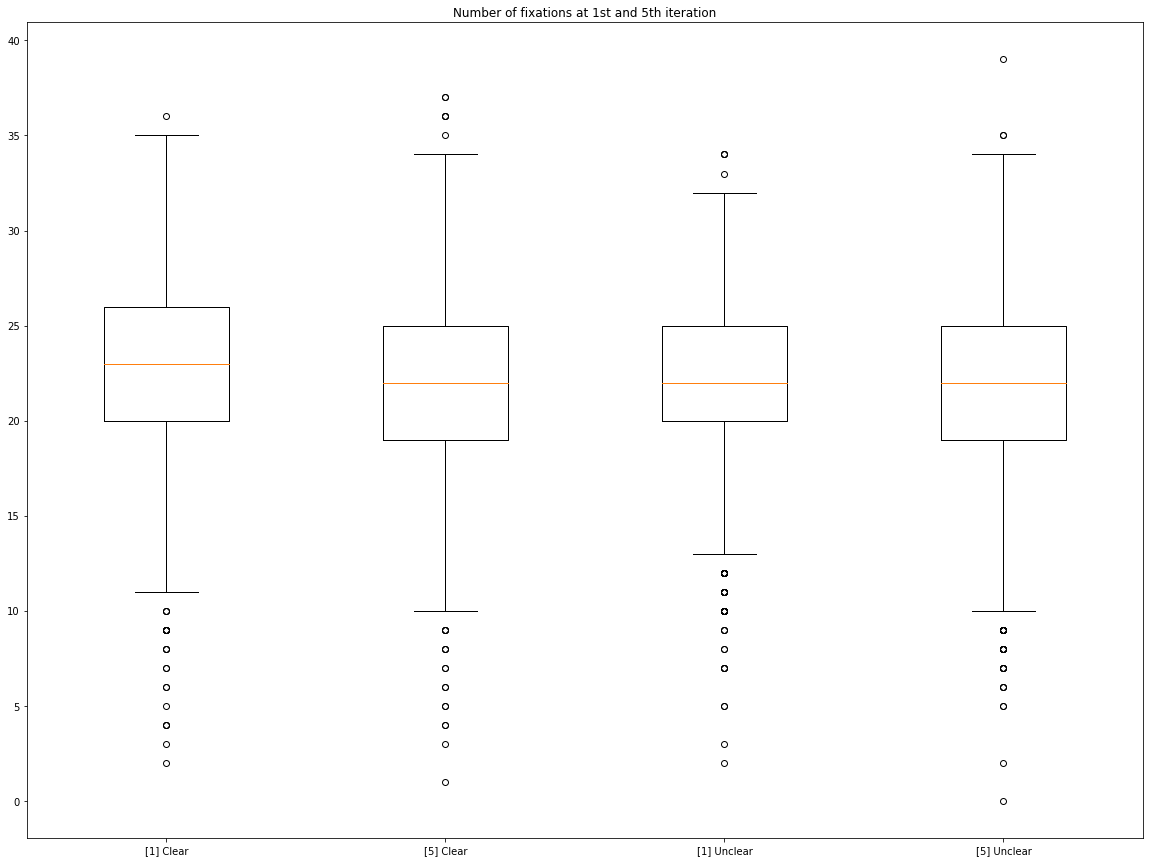

In [44]:
clear_nfixations_perimage = []
unclear_nfixations_perimage = []

clear_nfixations_perimage5 = []
unclear_nfixations_perimage5 = []

for i in range (0,len(matrix_number_fix_per_image),2):
    index=i+1
    for j in range (0,len(matrix_number_fix_per_image[index])):
        if(matrix_number_fix_per_image[i][0] in clear_images[0] or matrix_number_fix_per_image[i][0] in clear_images[1]):
            # print(matrix_number_fix_per_image[index][j])
            clear_nfixations_perimage.append(matrix_number_fix_per_image[index][j])
        else: unclear_nfixations_perimage.append(matrix_number_fix_per_image[index][j])
            
for i in range (0,len(matrix_number_fix_per_image5),2):
    index =i+1
    for j in range(0,len(matrix_number_fix_per_image5[index])):
        if(matrix_number_fix_per_image5[i][0]  in clear_images[0] or matrix_number_fix_per_image5[i][0] in clear_images[1]):
            # print(matrix_number_fix_per_image[index][j])
            clear_nfixations_perimage5.append(matrix_number_fix_per_image5[index][j])
        else:
            unclear_nfixations_perimage5.append(matrix_number_fix_per_image5[index][j])
                    
                    
                    
# #axs[0].set_yticks([0, 198, 500, 750, 100, 1250, 1750])
fig,ax=plt.subplots(figsize=(20,15))
n_fixations=[clear_nfixations_perimage,clear_nfixations_perimage5,unclear_nfixations_perimage,unclear_nfixations_perimage5]

ax.boxplot(n_fixations)
ax.set_title('Number of fixations at 1st and 5th iteration')
plt.xticks([1,2,3,4], ['[1] Clear','[5] Clear','[1] Unclear','[5] Unclear'])

## So, at first iteration we have more fixations than 5th iteration.

## Mean duration of fixation

Let's investigate about the mean duration of fixation at 1st iteration and 5th iteration: how does this value change? And how does it change between clear and unclear images?


In [45]:
total = 0
times_meanDuration1GreatherThanMeanDuration5= 0

for i in range (0, len(matrix_meanDuration_eachParticipant_perImage),2):
    index = i+1
    for j in range (0, len(matrix_meanDuration_eachParticipant_perImage[index])):
        total = total+1
#         print(matrix_meanDuration_eachParticipant_perImage[index][j])
        if(matrix_meanDuration_eachParticipant_perImage[index][j]<matrix_meanDuration_eachParticipant_perImage5[index][j]):
            times_meanDuration1GreatherThanMeanDuration5 = times_meanDuration1GreatherThanMeanDuration5+1
    
print((round(times_meanDuration1GreatherThanMeanDuration5/total*100),2),"% of times that mean duration of fixations of 5th iteration > mean duration of fixations of 1st iteration ")


######################################################################################################################################################

total_clear = 0
total_unclear = 0
clear_times_meanDuration5GreatherThanMeanDuration1 = 0
unclear_times_meanDuration5GreatherThanMeanDuration1 = 0

for i in range (0, len(matrix_meanDuration_eachParticipant_perImage),2):
    index = i+1
    for j in range (0, len(matrix_meanDuration_eachParticipant_perImage[index])):
#         print(matrix_meanDuration_eachParticipant_perImage[index][j])
        if(matrix_meanDuration_eachParticipant_perImage[i][0]  in clear_images[0] or matrix_meanDuration_eachParticipant_perImage[i][0] in clear_images[1]):
            total_clear=total_clear+1
            if(matrix_meanDuration_eachParticipant_perImage[index][j]<matrix_meanDuration_eachParticipant_perImage5[index][j]):
                clear_times_meanDuration5GreatherThanMeanDuration1 = clear_times_meanDuration5GreatherThanMeanDuration1+1
                
        elif(matrix_meanDuration_eachParticipant_perImage[i][0] in unclear_images[0] or matrix_meanDuration_eachParticipant_perImage[i][0] in unclear_images[1]):
            total_unclear=total_unclear+1
            if(matrix_meanDuration_eachParticipant_perImage[index][j]<matrix_meanDuration_eachParticipant_perImage5[index][j]):
                unclear_times_meanDuration5GreatherThanMeanDuration1 = unclear_times_meanDuration5GreatherThanMeanDuration1+1
      
    
print("\nIn particular:\n[CLEAR IMAGES]",(round(clear_times_meanDuration5GreatherThanMeanDuration1/total_clear*100),2),"% of times that mean duration of fixations of 5th iteration > mean duration of fixations of 1st iteration")
#[clear] 5th iteration's fixations LONGER in time than 1st iteration: focus on some details, trying to remember the image

print("[UNCLEAR IMAGES]",(round(unclear_times_meanDuration5GreatherThanMeanDuration1/total_unclear*100),2),"% of times that mean duration of fixations of 5th iteration > mean duration of fixations of 1st iteration")
#[unclear] 1st iteraiton's fixations LONGER in time than 5th iteration: since it was first time, longer fixations 
#to understand something. At the fifth time, shorter fixations as it is already remembered at first sight (primo impatto)


(80, 2) % of times that mean duration of fixations of 5th iteration > mean duration of fixations of 1st iteration 

In particular:
[CLEAR IMAGES] (86, 2) % of times that mean duration of fixations of 5th iteration > mean duration of fixations of 1st iteration
[UNCLEAR IMAGES] (70, 2) % of times that mean duration of fixations of 5th iteration > mean duration of fixations of 1st iteration


([<matplotlib.axis.XTick at 0x15484b52708>,
 [Text(1, 0, '[1] Clear'),
  Text(2, 0, '[5] Clear'),
  Text(3, 0, '[1] Unclear'),
  Text(4, 0, '[5] Unclear')])

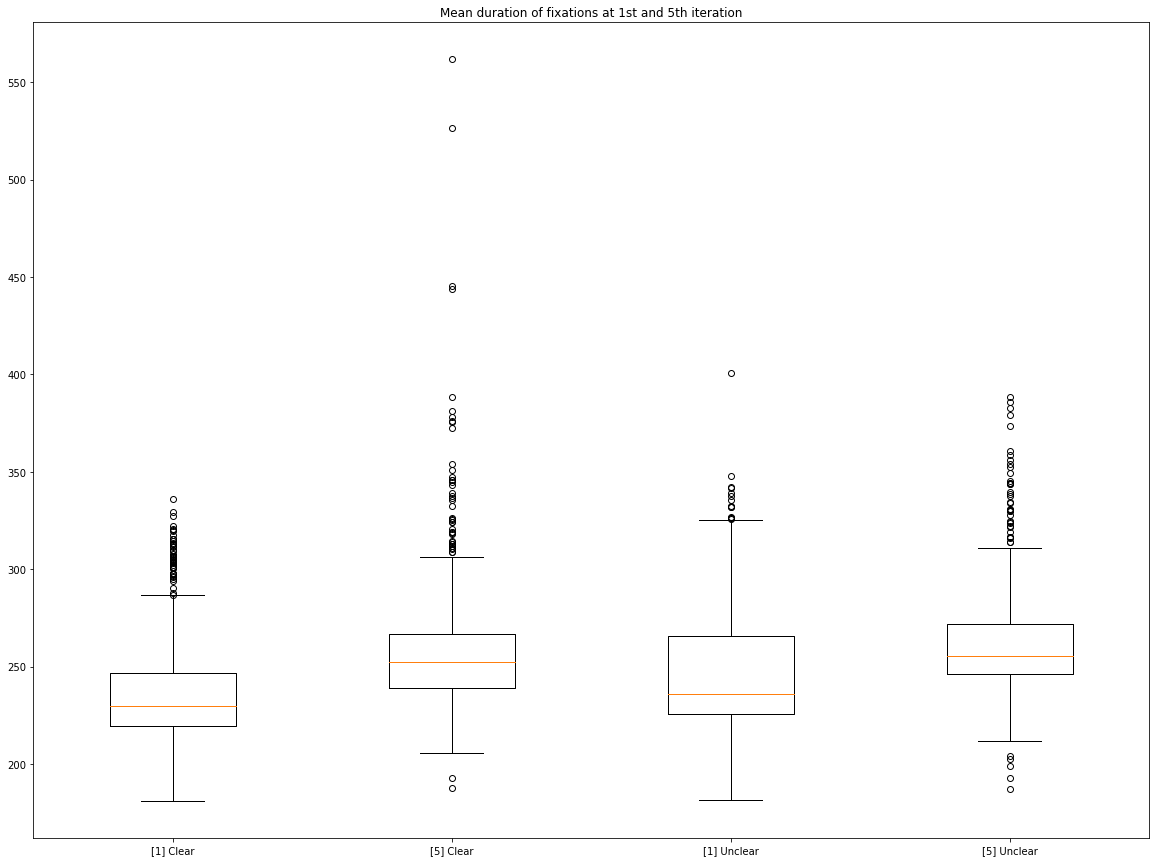

In [46]:
clear_meanduration_perimage = []
unclear_meanduration_perimage = []

clear_meanduration_perimage5 = []
unclear_meanduration_perimage5 = []

for i in range (0,len(matrix_meanDuration_eachParticipant_perImage),2):
    index=i+1
    for j in range (0,len(matrix_meanDuration_eachParticipant_perImage[index])):
        if(matrix_meanDuration_eachParticipant_perImage[i][0] in clear_images[0] or matrix_meanDuration_eachParticipant_perImage[i][0] in clear_images[1]):
            # print(matrix_number_fix_per_image[index][j])
            clear_meanduration_perimage.append(matrix_meanDuration_eachParticipant_perImage[index][j])
        else: unclear_meanduration_perimage.append(matrix_meanDuration_eachParticipant_perImage[index][j])
            
for i in range (0,len(matrix_meanDuration_eachParticipant_perImage5),2):
    index =i+1
    for j in range(0,len(matrix_meanDuration_eachParticipant_perImage5[index])):
        if(matrix_meanDuration_eachParticipant_perImage5[i][0]in clear_images[0] or matrix_meanDuration_eachParticipant_perImage5[i][0] in clear_images[1]):
            # print(matrix_number_fix_per_image[index][j])
            clear_meanduration_perimage5.append(matrix_meanDuration_eachParticipant_perImage5[index][j])
        else:
            unclear_meanduration_perimage5.append(matrix_meanDuration_eachParticipant_perImage5[index][j])

                    
                    
# #axs[0].set_yticks([0, 198, 500, 750, 100, 1250, 1750])
fig,ax=plt.subplots(figsize=(20,15))
n_durations=[clear_meanduration_perimage,clear_meanduration_perimage5,unclear_meanduration_perimage,unclear_meanduration_perimage5]

ax.boxplot(n_durations)
ax.set_title('Mean duration of fixations at 1st and 5th iteration')
plt.xticks([1,2,3,4], ['[1] Clear','[5] Clear','[1] Unclear','[5] Unclear'])

## Mean duration of fixation at 1st iteration is less than the mean duration at 5th iteration.


## Number of clusters


Let's investigate about the number of clusters at 1st iteration and 5th iteration: how does this value change? And how does it change between clear and unclear images?

In [47]:
total = 0
times_cluster1MoreThancluster5= 0

for i in range (0,len(matrix_nClusters_perImage),2):
    index = i+1
    for j in range (0, len(matrix_nClusters_perImage[index])):
        total = total+1
#         print(matrix_nClusters_perImage[index][j],",",matrix_nClusters_perImage5[index][j])

        if(matrix_nClusters_perImage[index][j][0]>=matrix_nClusters_perImage5[index][j][0]):
            times_cluster1MoreThancluster5 = times_cluster1MoreThancluster5+1
            
print((round(times_cluster1MoreThancluster5/total*100),2),"% of times that cluster of 1st iteration ARE EQUAL OR MORE THAN clusters of 5th iteration ")
######################################################################################################################################################
total_clear = 0
total_unclear = 0
clear_times_cluster1MoreThancluster5 = 0
unclear_times_cluster1MoreThancluster5 = 0

for i in range (0, len(matrix_nClusters_perImage),2):
    index = i+1
    for j in range (0, len(matrix_nClusters_perImage[index])):
#         print(matrix_meanDuration_eachParticipant_perImage[index][j])
        if(matrix_nClusters_perImage[i][0] in clear_images[0] or matrix_nClusters_perImage[i][0] in clear_images[1]):
            total_clear=total_clear+1
            if(matrix_nClusters_perImage[index][j]>=matrix_nClusters_perImage5[index][j]):
                clear_times_cluster1MoreThancluster5 = clear_times_cluster1MoreThancluster5+1
                
        elif(matrix_nClusters_perImage[i][0] in unclear_images[0] or matrix_nClusters_perImage[i][0] in unclear_images[1]):
            total_unclear=total_unclear+1
            if(matrix_nClusters_perImage[index][j]>=matrix_nClusters_perImage5[index][j]):
                unclear_times_cluster1MoreThancluster5 = unclear_times_cluster1MoreThancluster5+1
      
    
print("\nIn particular:\n[CLEAR IMAGES]",(round(clear_times_cluster1MoreThancluster5/total_clear*100),2),"% of times that clusters at 1st iteration are EQUAL OR MORE THAN cluster at 5th iteration")
#[clear] 5th iteration's fixations LONGER in time than 1st iteration: focus on some details, trying to remember the image

print("[UNCLEAR IMAGES]",(round(unclear_times_cluster1MoreThancluster5/total_unclear*100),2),"% of times that clusters at 1st iteration are EQUAL OR MORE THAN cluster at 5th iteration")
#[unclear] 1st iteraiton's fixations LONGER in time than 5th iteration: since it was first time, longer fixations 
#to understand something. At the fifth time, shorter fixations as it is already remembered at first sight (primo impatto)


(71, 2) % of times that cluster of 1st iteration ARE EQUAL OR MORE THAN clusters of 5th iteration 

In particular:
[CLEAR IMAGES] (72, 2) % of times that clusters at 1st iteration are EQUAL OR MORE THAN cluster at 5th iteration
[UNCLEAR IMAGES] (69, 2) % of times that clusters at 1st iteration are EQUAL OR MORE THAN cluster at 5th iteration


([<matplotlib.axis.XTick at 0x15484ff4248>,
 [Text(1, 0, '[1] Clear'),
  Text(2, 0, '[5] Clear'),
  Text(3, 0, '[1] Unclear'),
  Text(4, 0, '[5] Unclear')])

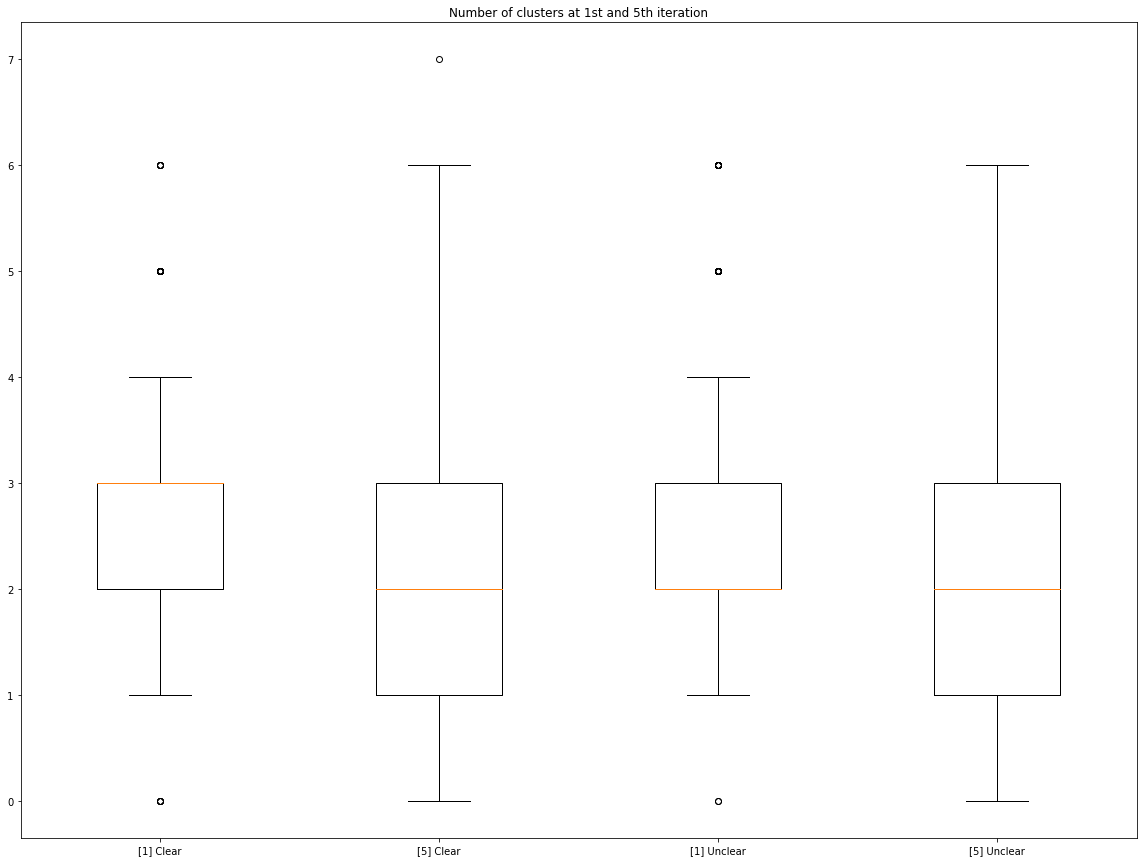

In [48]:
clear_clusters_perimage = []
unclear_clusters_perimage = []

clear_clusters_perimage5 = []
unclear_clusters_perimage5 = []

for i in range (0,len(matrix_nClusters_perImage),2):
    index=i+1
    for j in range (0,len(matrix_nClusters_perImage[index])):
        if(matrix_nClusters_perImage[i][0] in clear_images[0] or matrix_nClusters_perImage[i][0] in clear_images[1]):
            # print(matrix_number_fix_per_image[index][j])
            clear_clusters_perimage.append(matrix_nClusters_perImage[index][j][0])
        else: unclear_clusters_perimage.append(matrix_nClusters_perImage[index][j][0])
            
for i in range (0,len(matrix_nClusters_perImage5),2):
    index =i+1
    for j in range(0,len(matrix_nClusters_perImage5[index])):
        if(matrix_nClusters_perImage5[i][0] in clear_images[0] or matrix_nClusters_perImage5[i][0] in clear_images[1]):
            # print(matrix_number_fix_per_image[index][j])
            clear_clusters_perimage5.append(matrix_nClusters_perImage5[index][j][0])
        else:
            unclear_clusters_perimage5.append(matrix_nClusters_perImage5[index][j][0])
                    
                    
                    
# #axs[0].set_yticks([0, 198, 500, 750, 100, 1250, 1750])
fig,ax=plt.subplots(figsize=(20,15))
n_durations=[clear_clusters_perimage,clear_clusters_perimage5,unclear_clusters_perimage,unclear_clusters_perimage5]

ax.boxplot(n_durations)
ax.set_title('Number of clusters at 1st and 5th iteration')
plt.xticks([1,2,3,4], ['[1] Clear','[5] Clear','[1] Unclear','[5] Unclear'])

## So at 1st iteration we have at least the same number of cluster both in clear and in unclear

## Noise points 

Let's investigate about the number of noise points at 1st iteration and 5th iteration: how does this value change? And how does it change between clear and unclear images?

In [49]:
total = 0
times_noise1MoreThanNoise5= 0

for i in range (0,len(matrix_nNoise_perImage),2):
    index = i+1
    for j in range (0, len(matrix_nNoise_perImage[index])):
        total = total+1

        if(matrix_nNoise_perImage[index][j][0]>=matrix_nNoise_perImage5[index][j][0]):
            times_noise1MoreThanNoise5 = times_noise1MoreThanNoise5+1
            
print((round(times_noise1MoreThanNoise5/total*100),2),"% of times that noise points of 1st iteration ARE EQUAL OR MORE THAN noise points of 5th iteration ")
######################################################################################################################################################
total_clear = 0
total_unclear = 0
clear_times_noise1MoreThanNoise5 = 0
unclear_times_noise1MoreThanNoise5 = 0

for i in range (0, len(matrix_nNoise_perImage),2):
    index = i+1
    for j in range (0, len(matrix_nNoise_perImage[index])):
#         print(matrix_meanDuration_eachParticipant_perImage[index][j])
        if(matrix_nNoise_perImage[i][0] in clear_images[0] or matrix_nNoise_perImage[i][0] in clear_images[1]):
            total_clear=total_clear+1
            if(matrix_nNoise_perImage[index][j]>=matrix_nNoise_perImage5[index][j]):
                clear_times_noise1MoreThanNoise5 = clear_times_noise1MoreThanNoise5+1
                
        elif(matrix_nNoise_perImage[i][0] in unclear_images[0] or matrix_nNoise_perImage[i][0] in unclear_images[1]):
            total_unclear=total_unclear+1
            if(matrix_nNoise_perImage[index][j]>=matrix_nNoise_perImage5[index][j]):
                unclear_times_noise1MoreThanNoise5 = unclear_times_noise1MoreThanNoise5+1
      
    
print("\nIn particular:\n[CLEAR IMAGES]",(round(clear_times_noise1MoreThanNoise5/total_clear*100),2),"% of times that noise points at 1st iteration are EQUAL OR MORE THAN noise points at 5th iteration")
#[clear] 5th iteration's fixations LONGER in time than 1st iteration: focus on some details, trying to remember the image

print("[UNCLEAR IMAGES]",(round(unclear_times_noise1MoreThanNoise5/total_unclear*100),2),"% of times that noise points at 1st iteration are EQUAL OR MORE THAN noise points at 5th iteration")
#[unclear] 1st iteraiton's fixations LONGER in time than 5th iteration: since it was first time, longer fixations 
#to understand something. At the fifth time, shorter fixations as it is already remembered at first sight (primo impatto)


(58, 2) % of times that noise points of 1st iteration ARE EQUAL OR MORE THAN noise points of 5th iteration 

In particular:
[CLEAR IMAGES] (59, 2) % of times that noise points at 1st iteration are EQUAL OR MORE THAN noise points at 5th iteration
[UNCLEAR IMAGES] (58, 2) % of times that noise points at 1st iteration are EQUAL OR MORE THAN noise points at 5th iteration


([<matplotlib.axis.XTick at 0x154850cc608>,
 [Text(1, 0, '[1] Clear'),
  Text(2, 0, '[5] Clear'),
  Text(3, 0, '[1] Unclear'),
  Text(4, 0, '[5] Unclear')])

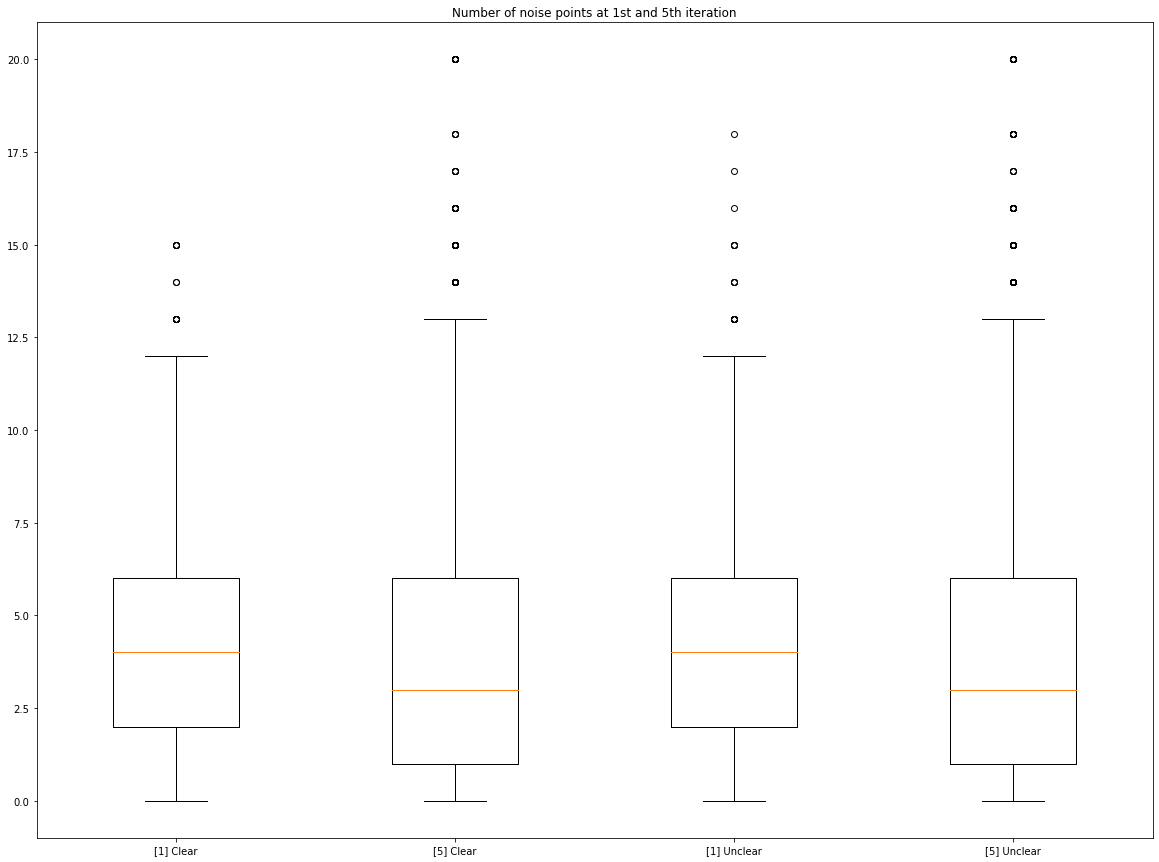

In [50]:
clear_noisepoints_perimage = []
unclear_noisepoints_perimage = []

clear_noisepoints_perimage5 = []
unclear_noisepoints_perimage5 = []

for i in range (0,len(matrix_nNoise_perImage),2):
    index=i+1
    for j in range (0,len(matrix_nNoise_perImage[index])):
        if(matrix_nNoise_perImage[i][0] in clear_images[0] or matrix_nNoise_perImage[i][0] in clear_images[1]):
            # print(matrix_number_fix_per_image[index][j])
            clear_noisepoints_perimage.append(matrix_nNoise_perImage[index][j][0])
        else: unclear_noisepoints_perimage.append(matrix_nNoise_perImage[index][j][0])
            
for i in range (0,len(matrix_nNoise_perImage5),2):
    index =i+1
    for j in range(0,len(matrix_nNoise_perImage5[index])):
        if(matrix_nNoise_perImage5[i][0] in clear_images[0] or matrix_nNoise_perImage5[i][0] in clear_images[1]):
            # print(matrix_number_fix_per_image[index][j])
            clear_noisepoints_perimage5.append(matrix_nNoise_perImage5[index][j][0])
        else:
            unclear_noisepoints_perimage5.append(matrix_nNoise_perImage5[index][j][0])
                    
                    
                    
# #axs[0].set_yticks([0, 198, 500, 750, 100, 1250, 1750])
fig,ax=plt.subplots(figsize=(20,15))
n_durations=[clear_noisepoints_perimage,clear_noisepoints_perimage5,unclear_noisepoints_perimage,unclear_noisepoints_perimage5]

ax.boxplot(n_durations)
ax.set_title('Number of noise points at 1st and 5th iteration')
plt.xticks([1,2,3,4], ['[1] Clear','[5] Clear','[1] Unclear','[5] Unclear'])

## So at 1st iteration we have at least the same number of noise points both in clear and unclear images

## [1ST ITERATION] Silhouette scores

Let's investigate about the silhouette score at 1st iteration: how does this value is distributed? And how does it change between clear and unclear images?

In [51]:
occurrences_almost_minus1_1stIt = 0 ###tra -1 e -0.5
occurrences_0negative_1stIt = 0 ###tra -0.5 e 0
occurrences_0positive_1stIt = 0 ###tra 0.5 e 0
occurrences_almost1_1stIt = 0 #0.5 e 1

total = 0
# print(len(matrix_SilhScore[69]))
for i in range (0, len(matrix_SilhScore),2):
    index = i+1
    for j in range (0, len(matrix_SilhScore[index])):
        total = total+1
        if(matrix_SilhScore[index][j][0]<-0.5 and matrix_SilhScore[index][j][0]!=-5):
#             print(matrix_SilhScore[index][j])
            occurrences_almost_minus1_1stIt = occurrences_almost_minus1_1stIt+1
        elif(matrix_SilhScore[index][j][0]>=-0.5 and matrix_SilhScore[index][j][0]<0):
#             print(matrix_SilhScore[index][j])
            occurrences_0negative_1stIt = occurrences_0negative_1stIt+1
        elif(matrix_SilhScore[index][j][0]>=0 and matrix_SilhScore[index][j][0]<0.5):
#             print(matrix_SilhScore[index][j])
            occurrences_0positive_1stIt = occurrences_0positive_1stIt+1
        elif(matrix_SilhScore[index][j][0]>=0.5):
#             print(matrix_SilhScore[index][j])
            occurrences_almost1_1stIt = occurrences_almost1_1stIt+1
            
print("Silhouette score less than -0.5: ", round((occurrences_almost_minus1_1stIt/total)*100,2),"%")
print("Silhouette score between -0.5 and 0: ", round((occurrences_0negative_1stIt/total)*100,2),"%")
print("Silhouette score between 0 and 0.5: ", round((occurrences_0positive_1stIt/total)*100,2),"%")
print("Silhouette score greather than 0.5: ", round((occurrences_almost1_1stIt/total)*100,2),"%")
print("In the other cases (less thant 4%) cluster was just one and so it was not possible to calculate this score")

Silhouette score less than -0.5:  3.52 %
Silhouette score between -0.5 and 0:  0.05 %
Silhouette score between 0 and 0.5:  53.77 %
Silhouette score greather than 0.5:  42.66 %
In the other cases (less thant 4%) cluster was just one and so it was not possible to calculate this score


## Clear images

In [52]:
total_clear = 0
total_unclear = 0

clear_occurrences_almost_minus1_1stIt = 0 ###tra -1 e -0.5
clear_occurrences_0negative_1stIt = 0 ###tra -0.5 e 0
clear_occurrences_0positive_1stIt = 0 ###tra 0.5 e 0
clear_occurrences_almost1_1stIt = 0 #0.5 e 1

# print(len(matrix_SilhScore[69]))
for i in range (0, len(matrix_SilhScore),2):
    index = i+1
    for j in range (0, len(matrix_SilhScore[index])):
        if(matrix_SilhScore[i][0] in clear_images[0] or matrix_SilhScore[i][0] in clear_images[1]):
            total_clear = total_clear +1
            if(matrix_SilhScore[index][j][0]<-0.5 and matrix_SilhScore[index][j][0]!=-5):
    #             print(matrix_SilhScore[index][j])
                clear_occurrences_almost_minus1_1stIt = clear_occurrences_almost_minus1_1stIt+1
            elif(matrix_SilhScore[index][j][0]>=-0.5 and matrix_SilhScore[index][j][0]<0):
    #             print(matrix_SilhScore[index][j])
                clear_occurrences_0negative_1stIt = clear_occurrences_0negative_1stIt+1
            elif(matrix_SilhScore[index][j][0]>=0 and matrix_SilhScore[index][j][0]<0.5):
    #             print(matrix_SilhScore[index][j])
                clear_occurrences_0positive_1stIt = clear_occurrences_0positive_1stIt+1
            elif(matrix_SilhScore[index][j][0]>=0.5):
    #             print(matrix_SilhScore[index][j])
                clear_occurrences_almost1_1stIt = clear_occurrences_almost1_1stIt+1

print("[CLEAR] Silhouette score less than -0.5: ", round((clear_occurrences_almost_minus1_1stIt/total_clear)*100,2),"%")
print("[CLEAR] Silhouette score between -0.5 and 0: ", round((clear_occurrences_0negative_1stIt/total_clear)*100,2),"%")
print("[CLEAR] Silhouette score between 0 and 0.5: ", round((clear_occurrences_0positive_1stIt/total_clear)*100,2),"%")
print("[CLEAR] Silhouette score greather than 0.5: ", round((clear_occurrences_almost1_1stIt/total_clear)*100,2),"%")
print("[CLEAR] In the other cases (less thant 3%) cluster was just one and so it was not possible to calculate this score")

[CLEAR] Silhouette score less than -0.5:  3.28 %
[CLEAR] Silhouette score between -0.5 and 0:  0.11 %
[CLEAR] Silhouette score between 0 and 0.5:  54.07 %
[CLEAR] Silhouette score greather than 0.5:  42.54 %
[CLEAR] In the other cases (less thant 3%) cluster was just one and so it was not possible to calculate this score


## UNCLEAR

In [53]:
total_unclear = 0

unclear_occurrences_almost_minus1_1stIt = 0 ###tra -1 e -0.5
unclear_occurrences_0negative_1stIt = 0 ###tra -0.5 e 0
unclear_occurrences_0positive_1stIt = 0 ###tra 0.5 e 0
unclear_occurrences_almost1_1stIt = 0 #0.5 e 1

# print(len(matrix_SilhScore[69]))
for i in range (0, len(matrix_SilhScore),2):
    index = i+1
    for j in range (0, len(matrix_SilhScore[index])):
        if(matrix_SilhScore[i][0] in unclear_images[0] or matrix_SilhScore[i][0] in unclear_images[1]):
            total_unclear = total_unclear +1
            if(matrix_SilhScore[index][j][0]<-0.5 and matrix_SilhScore[index][j][0]!=-5):
    #             print(matrix_SilhScore[index][j])
                unclear_occurrences_almost_minus1_1stIt = unclear_occurrences_almost_minus1_1stIt+1
            elif(matrix_SilhScore[index][j][0]>=-0.5 and matrix_SilhScore[index][j][0]<0):
    #             print(matrix_SilhScore[index][j])
                unclear_occurrences_0negative_1stIt = unclear_occurrences_0negative_1stIt+1
            elif(matrix_SilhScore[index][j][0]>=0 and matrix_SilhScore[index][j][0]<0.5):
    #             print(matrix_SilhScore[index][j])
                unclear_occurrences_0positive_1stIt = unclear_occurrences_0positive_1stIt+1
            elif(matrix_SilhScore[index][j][0]>=0.5):
    #             print(matrix_SilhScore[index][j])
                unclear_occurrences_almost1_1stIt = unclear_occurrences_almost1_1stIt+1

print("[UNCLEAR] Silhouette score less than -0.5: ", round((unclear_occurrences_almost_minus1_1stIt/total_unclear)*100,2),"%")
print("[UNCLEAR] Silhouette score between -0.5 and 0: ", round((unclear_occurrences_0negative_1stIt/total_unclear)*100,2),"%")
print("[UNCLEAR] Silhouette score between 0 and 0.5: ", round((unclear_occurrences_0positive_1stIt/total_unclear)*100,2),"%")
print("[UNCLEAR] Silhouette score greather than 0.5: ", round((unclear_occurrences_almost1_1stIt/total_unclear)*100,2),"%")
print("[UNCLEAR] In the other cases (less thant 4%) cluster was just one and so it was not possible to calculate this score")

[UNCLEAR] Silhouette score less than -0.5:  2.96 %
[UNCLEAR] Silhouette score between -0.5 and 0:  0.0 %
[UNCLEAR] Silhouette score between 0 and 0.5:  58.52 %
[UNCLEAR] Silhouette score greather than 0.5:  38.52 %
[UNCLEAR] In the other cases (less thant 4%) cluster was just one and so it was not possible to calculate this score


## [5TH ITERATION] SILHOUETTE SCORE 

Let's investigate about the silhouette score at 5th iteration: how does this value is distributed? And how does it change between clear and unclear images?

In [54]:
occurrences_almost_minus1_5thIt = 0 ###tra -1 e -0.5
occurrences_0negative_5thtIt = 0 ###tra -0.5 e 0
occurrences_0positive_5thIt = 0 ###tra 0.5 e 0
occurrences_almost1_5thIt = 0 #0.5 e 1

total = 0
# print(len(matrix_SilhScore[69]))
for i in range (0, len(matrix_SilhScore5),2):
    index = i+1
    for j in range (0, len(matrix_SilhScore5[index])):
        total = total+1
        if(matrix_SilhScore5[index][j][0]<-0.5 and matrix_SilhScore5[index][j][0]!=-5):
#             print(matrix_SilhScore[index][j])
            occurrences_almost_minus1_5thIt = occurrences_almost_minus1_5thIt+1
        elif(matrix_SilhScore5[index][j][0]>=-0.5 and matrix_SilhScore5[index][j][0]<0):
#             print(matrix_SilhScore[index][j])
            occurrences_0negative_5thtIt = occurrences_0negative_5thtIt+1
        elif(matrix_SilhScore5[index][j][0]>=0 and matrix_SilhScore5[index][j][0]<0.5):
#             print(matrix_SilhScore[index][j])
            occurrences_0positive_5thIt = occurrences_0positive_5thIt+1
        elif(matrix_SilhScore5[index][j][0]>=0.5):
#             print(matrix_SilhScore[index][j])
            occurrences_almost1_5thIt = occurrences_almost1_5thIt+1
            
print("Silhouette score less than -0.5: ", round((occurrences_almost_minus1_5thIt/total)*100,2),"%")
print("Silhouette score between -0.5 and 0: ", round((occurrences_0negative_5thtIt/total)*100,2),"%")
print("Silhouette score between 0 and 0.5: ", round((occurrences_0positive_5thIt/total)*100,2),"%")
print("Silhouette score greather than 0.5: ", round((occurrences_almost1_5thIt/total)*100,2),"%")
print("In the other cases (less thant 8%) cluster was just one and so it was not possible to calculate this score")

Silhouette score less than -0.5:  9.08 %
Silhouette score between -0.5 and 0:  0.09 %
Silhouette score between 0 and 0.5:  42.15 %
Silhouette score greather than 0.5:  48.68 %
In the other cases (less thant 8%) cluster was just one and so it was not possible to calculate this score


## CLEAR 

In [55]:
total_clear = 0
total_unclear = 0

clear_occurrences_almost_minus1_5thIt = 0 ###tra -1 e -0.5
clear_occurrences_0negative_5thIt = 0 ###tra -0.5 e 0
clear_occurrences_0positive_5thIt = 0 ###tra 0.5 e 0
clear_occurrences_almost1_5thIt = 0 #0.5 e 1

# print(len(matrix_SilhScore[69]))
for i in range (0, len(matrix_SilhScore5),2):
    index = i+1
    for j in range (0, len(matrix_SilhScore5[index])):
        if(matrix_SilhScore5[i][0]in clear_images[0] or matrix_SilhScore5[i][0] in clear_images[1]):
            total_clear = total_clear +1
            if(matrix_SilhScore5[index][j][0]<-0.5 and matrix_SilhScore5[index][j][0]!=-5):
    #             print(matrix_SilhScore[index][j])
                clear_occurrences_almost_minus1_5thIt = clear_occurrences_almost_minus1_5thIt+1
            elif(matrix_SilhScore5[index][j][0]>=-0.5 and matrix_SilhScore5[index][j][0]<0):
    #             print(matrix_SilhScore[index][j])
                clear_occurrences_0negative_5thIt = clear_occurrences_0negative_5thIt+1
            elif(matrix_SilhScore5[index][j][0]>=0 and matrix_SilhScore5[index][j][0]<0.5):
    #             print(matrix_SilhScore[index][j])
                clear_occurrences_0positive_5thIt = clear_occurrences_0positive_5thIt+1
            elif(matrix_SilhScore5[index][j][0]>=0.5):
    #             print(matrix_SilhScore[index][j])
                clear_occurrences_almost1_5thIt = clear_occurrences_almost1_5thIt+1

print("Silhouette score less than -0.5: ", round((clear_occurrences_almost_minus1_5thIt/total_clear)*100,2),"%")
print("Silhouette score between -0.5 and 0: ", round((clear_occurrences_0negative_5thIt/total_clear)*100,2),"%")
print("Silhouette score between 0 and 0.5: ", round((clear_occurrences_0positive_5thIt/total_clear)*100,2),"%")
print("Silhouette score greather than 0.5: ", round((clear_occurrences_almost1_5thIt/total_clear)*100,2),"%")
print("In the other cases (less thant 6%) cluster was just one and so it was not possible to calculate this score")

Silhouette score less than -0.5:  8.25 %
Silhouette score between -0.5 and 0:  0.11 %
Silhouette score between 0 and 0.5:  43.07 %
Silhouette score greather than 0.5:  48.57 %
In the other cases (less thant 6%) cluster was just one and so it was not possible to calculate this score


## UNCLEAR

In [56]:
total_clear = 0
total_unclear = 0

unclear_occurrences_almost_minus1_5thIt = 0 ###tra -1 e -0.5
unclear_occurrences_0negative_5thIt = 0 ###tra -0.5 e 0
unclear_occurrences_0positive_5thIt = 0 ###tra 0.5 e 0
unclear_occurrences_almost1_5thIt = 0 #0.5 e 1

# print(len(matrix_SilhScore[69]))
for i in range (0, len(matrix_SilhScore5),2):
    index = i+1
    for j in range (0, len(matrix_SilhScore5[index])):
        if(matrix_SilhScore5[i][0] in unclear_images[0] or matrix_SilhScore5[i][0] in unclear_images[1]):
            total_unclear = total_unclear +1
            if(matrix_SilhScore5[index][j][0]<-0.5 and matrix_SilhScore5[index][j][0]!=-5):
    #             print(matrix_SilhScore[index][j])
                unclear_occurrences_almost_minus1_5thIt = unclear_occurrences_almost_minus1_5thIt+1
            elif(matrix_SilhScore5[index][j][0]>=-0.5 and matrix_SilhScore5[index][j][0]<0):
    #             print(matrix_SilhScore[index][j])
                unclear_occurrences_0negative_5thIt = unclear_occurrences_0negative_5thIt+1
            elif(matrix_SilhScore5[index][j][0]>=0 and matrix_SilhScore5[index][j][0]<0.5):
    #             print(matrix_SilhScore[index][j])
                unclear_occurrences_0positive_5thIt = unclear_occurrences_0positive_5thIt+1
            elif(matrix_SilhScore5[index][j][0]>=0.5):
    #             print(matrix_SilhScore[index][j])
                unclear_occurrences_almost1_5thIt = unclear_occurrences_almost1_5thIt+1

print("Silhouette score less than -0.5: ", round((unclear_occurrences_almost_minus1_5thIt/total_unclear)*100,2),"%")
print("Silhouette score between -0.5 and 0: ", round((unclear_occurrences_0negative_5thIt/total_unclear)*100,2),"%")
print("Silhouette score between 0 and 0.5: ", round((unclear_occurrences_0positive_5thIt/total_unclear)*100,2),"%")
print("Silhouette score greather than 0.5: ", round((unclear_occurrences_almost1_5thIt/total_unclear)*100,2),"%")
print("In the other cases (less thant 10%) cluster was just one and so it was not possible to calculate this score")

Silhouette score less than -0.5:  6.96 %
Silhouette score between -0.5 and 0:  0.15 %
Silhouette score between 0 and 0.5:  46.67 %
Silhouette score greather than 0.5:  46.22 %
In the other cases (less thant 10%) cluster was just one and so it was not possible to calculate this score


## WHAT IS DIFFERENCE BETWEEN 1ST ITERATION AND 5TH ITERATION?

CLEAR IMAGES

At 1st iteration we have 54% of silhoette score between 0 and 0.5 
                    and 42% of silhoette score greater than 0.5.
                    
At 5th iteration we have 43 of silhoette score between 0 and 0.5 
                        48 % of silhoette score greater than 0.5.
                        
So we have a decrease in terms of clusters quitely distinguished and an increase of clusters well distinguished.
What does it changes? Clusters become more distinguished and separated, as participants' fixation are more clustered: they already know which details focusing on, and they don't spread their gaze in the whole picture.

UNCLEAR IMAGES:

1st iteation: 58% between 0 and 0.5
                38 greater than 0.5
                
5th iteraiton: 46 % between 0 and 0.5
                46% greater than 0.5
                
We have a decrease in terms of clusters quitely distinguished but an increase of clusters well distinguished: different values but same trend. Clusters become more distinguished!


# LET'S BUILD THE DATASET

## It will contain a row per each participant per each image.

## Each row will contain: 
### - Image category: 0 for clear images, 1 for unclear images
### - Number of fixations
### - Mean duration of fixations
### - Number of clusters
### - Number of noise points
### - Silhouette score
### - CLASS: 0 for data of 1st iteration, 1 for the 5th ones.

## CLASS will be the binary otput

Let's start: fill the dataset row by row, thanks to the matrices that we have built before.

In [57]:
import csv

filenumber_clear = np.append(clear_images[0],clear_images[1])
filenumber_unclear = np.append(unclear_images[0],unclear_images[1])
filenumber = np.append(filenumber_clear, filenumber_unclear)
filenumber.sort() #filenumber contains all the id of all the images of all categories
print(filenumber.shape)
index = 1

# print(filenumber)

with open("dataset.csv", "w", newline='') as f:
        fieldnames = ['image category', '# fixations','mean duration','# clusters','# noise points','silhouette score','CLASS']
        thewriter = csv.DictWriter(f, fieldnames= fieldnames)
        
        thewriter.writeheader()
        
        for i in filenumber:
#             print(index)
            if(i in clear_images[0] or i in clear_images[1]):
#                 print(i)
                imagecategory = 0
            else: imagecategory = 1 
            for j in range (0,45):
                if(index==79 and j==44): #matrices about clusters, noise points and silhouette have one value fewer: assign 0 for that row
                     thewriter.writerow({
                                    'image category' : imagecategory,
                                    '# fixations' : matrix_number_fix_per_image[index][j],
                                    'mean duration' : matrix_meanDuration_eachParticipant_perImage[index][j],
                                    '# clusters' : 0,
                                    '# noise points' : 0,
                                    'silhouette score'  : 0,
                                    'CLASS' : 1
                                })
                else:
                    if(matrix_SilhScore[index][j][0]!=-17): #-17 was the arbitray value chosen for silhoette score that cannot be calculated
                        thewriter.writerow({
                                    'image category' : imagecategory,
                                    '# fixations' : matrix_number_fix_per_image[index][j],
                                    'mean duration' : matrix_meanDuration_eachParticipant_perImage[index][j],
                                    '# clusters' : matrix_nClusters_perImage[index][j][0],
                                    '# noise points' : matrix_nNoise_perImage[index][j][0],
                                    'silhouette score'  : matrix_SilhScore[index][j][0],
                                    'CLASS' : 1
                                })
            index = index+2
            
            
        index = 1
        for i in filenumber:
#             print(index)
            if(i in clear_images[0] or i in clear_images[1]):
#                 print(i)
                imagecategory = 0
            else: imagecategory = 1 
            for j in range (0,45):
                if(index==79 and j==44):
                     thewriter.writerow({
                                    'image category' : imagecategory,
                                    '# fixations' : matrix_number_fix_per_image5[index][j],
                                    'mean duration' : matrix_meanDuration_eachParticipant_perImage5[index][j],
                                    '# clusters' : 0,
                                    '# noise points' : 0,
                                    'silhouette score'  : 0,
                                    'CLASS' : 5
                                })
                else:
                    if(matrix_SilhScore5[index][j][0]!=-17):
                        thewriter.writerow({
                                    'image category' : imagecategory,
                                    '# fixations' : matrix_number_fix_per_image5[index][j],
                                    'mean duration' : matrix_meanDuration_eachParticipant_perImage5[index][j],
                                    '# clusters' : matrix_nClusters_perImage5[index][j][0],
                                    '# noise points' : matrix_nNoise_perImage5[index][j][0],
                                    'silhouette score'  : matrix_SilhScore5[index][j][0],
                                    'CLASS' : 5
                                })
            index = index+2


(48,)
